#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
# !pip install monai
# !pip install nibabel
# !pip install SimpleITK
# !pip install tensorboard

In [2]:
MODEL_TO_LOAD = 'bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_model_epoch1000'
FN_LOSS = 0
LEVELS = 6
TRAINING_NAME = f'3D_Unet_DropRes_lv{LEVELS}_All192_1chin'
TB_PREFIX = 'bonemeta_fn_{}'.format(FN_LOSS) + '_{}'.format(TRAINING_NAME)

PATCH_SIZE = 192

# BATCH_SIZE = 120
BATCH_SIZE = 1
EPOCHS = 1000

BASE_DIR = '/workspace/BoneMeta_all_192'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels'

In [3]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [4]:
# !git clone https://github.com/JungOhLee/bonemeta_model.git ./git_clone
# !mv  -v ./git_clone/* .

In [5]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [6]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_all_192/images 317
/workspace/BoneMeta_all_192/labels 317


In [7]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [8]:
# # z축 작은 녀석들만 남기기 
# SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
# SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
# IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
# len(IMG_FILES)

In [9]:
TRAIN_FILES = ['KH027_20210801_Chest(+).npy', 'SN005_20191101_CT_Chest_+_3D_(contr.npy', 'BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000311_20190902_Chest_CT_(contrast).npy', 'BH023_20191101_Abdomen_&_pelvis_CT_(3D).npy', 'BH076_20180605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH121_20200301_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000506_20201113_Chest_CT_(contrast).npy', 'BH069_20200505_Chest_CT_(contrast)_+_3D.npy', 'KH039_20210301_Chest_(-)_Routine.npy', 'KH042_20210501_Chest(+).npy', 'BH016_20151001_Abdomen_&_pelvis_CT_(3D).npy', 'BH104_20161219_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000362_20191201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH035_20191101_GU_Kidney_&_bladder_CT_(3D).npy', '000423_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN036_20190601_CT_Chest_+_3D_(contr.npy', 'BH101_20201109_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN025_20200401_CT_Chest_+_3D_(contr.npy', '000364_20191217_Chest_CT_(contrast).npy', 'BH085_20200801_Abdomen_&_pelvis_CT.npy', 'KH023_20210901_Chest(+).npy', 'BH063_20200519_Chest_CT_(Non_contrast)_+_3D(Breast).npy', '000224_20190228_Chest_CT_(contrast).npy', 'BH116_20180606_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH023_20191101_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH055_20200328_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH002_20210301_Abdomen^00_AbdomenRoutine_(Adult).npy', '000370_20200101_CT_Abdomen+Pelvis_Post_(contrast).npy', '000363_20191222_Chest_3DCT_(contrast).npy', 'BH020_20191201_Chest_CT_(Non_contrast)_+_3D.npy', 'BH015_20190101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH016_20191101_Chest(+).npy', '000262_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH081_20190322_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190701_CT_Abdomen+Pelvis_Post_(contrast).npy', 'SN042_20170901_CT_Chest_+_3D_(contr.npy', 'BH071_20160826_Chest_CT_(contrast)_+_3D.npy', '000356_20191024_Chest_CT_(contrast).npy', '000162_20180131_Chest_CT_(contrast).npy', '000269_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH119_20200303_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Abdomen_&_pelvis_CT_(3D).npy', 'SN031_20160501_2-CT_Chest_Lung_cancer.npy', '000530_20210428_Chest_CT_(contrast).npy', 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000363_20191201_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH001_20210501_Chest(+).npy', 'KH031_20210801_Chest(+).npy', 'KH010_20201201_Chest(+).npy', '000370_20200117_Chest_CT_(contrast).npy', 'BH037_20171125_Abdomen_&_pelvis_CT_(3D).npy', '000080_20180911_Chest_CT_(contrast).npy', '000262_20190318_Chest_CT_(contrast).npy', 'BH117_20180506_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH034_20190923_GU_OBGY,Abd-pelvis_CT(pre&post)_(3D).npy', 'BH123_20201023_Abdomen_&_pelvis_CT.npy', 'BH061_20190315_Abdomen_&_pelvis_CT_(3D).npy', 'KH007_20200601_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH028_20190801_Chest_CT_(contrast)_+_3D.npy', '000085_20180829_Chest_CT_(contrast).npy', '000010_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000435_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH019_20191101_Thorax^02_Chest_CON_(Adult).npy', '000386_20200204_Chest_CT_(contrast).npy', '000466_20210128_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH098_20200626_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000325_20190919_Chest_CT_(contrast).npy', '000481_20210305_Thorax^Lung_Pre_(Adult).npy', 'BH108_20180228_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_Chest(+).npy', 'SN051_20170401_CT_Chest_+_3D_(contrast_NO_CM).npy', 'BH056_20200721_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_IM_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH091_20200104_GU_Kidney_&_bladder_CT_(3D).npy', 'BH064_20200605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH070_20160823_Abdomen_&_pelvis_CT_(3D).npy', 'BH089_20200811_Abdomen_&_pelvis_CT.npy', 'KH043_20210601_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy', '000279_20190614_Chest_3DCT_(contrast).npy', 'BH031_20160301_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH080_20181210_Abdomen_&_pelvis_CT_(3D).npy', 'BH036_20180301_GU_Kidney_&_bladder_CT_(3D).npy', '000272_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000079_20180911_Pulmonary_artery_CT_Angio+3D_(contrast).npy', '000022_20180830_Chest_CT_(contrast).npy', 'KH026_20210801_Chest(+).npy', 'BH120_20200406_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH073_20201223_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH100_20201007_Thorax^02_Chest_CON_(Adult).npy', 'BH086_20190812_Chest_CT_(Contrast)_+_3D(TS).npy', '000322_20190913_Chest_CT_(contrast).npy', 'BH095_20200727_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH016_20191101_Chest(+)_+_Abdomen_&_Pelvis(+).npy', 'SN028_20160801_CT_Abdomen+Pelvis_3D_(contrast).npy', 'SN055_20170301_CT_Chest_Low_Dose_+.npy', 'KH037_20210401_Chest(+).npy', '000309_20190823_Chest_CT_(contrast).npy', 'SN019_20190801_CT_Abdomen+Pelvis_Ar.npy', '000404_20200201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000528_20210514_Chest_CT_(contrast).npy', '000301_20190827_Chest_CT_(contrast).npy', '000424_20200218_Chest_CT_(contrast).npy', 'BH061_20190315_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH120_20200304_Chest_CT_(contrast)_+_3D.npy', 'BH105_20160820_Chest_CT_(contrast)_+_3D.npy', 'BH123_20201023_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH005_20170701_Abdomen_&_pelvis_CT_(3D).npy', 'BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy', '000262_20190529_Chest_CT_(contrast).npy', 'BH013_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000481_20200722_Chest_CT_(noncontrast).npy', 'BH012_20180401_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH054_20191122_Abdomen^00_Liver_CT_(Adult).npy', '000011_20181207_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH059_20201013_Abdomen_&_pelvis_CT.npy', 'BH082_20200416_Chest_CT_(contrast)_+_3D.npy', 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH121_20200301_Abdomen_&_pelvis_CT_(3D).npy', 'SN007_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000409_20200310_Chest_CT_(contrast).npy', 'BH111_20161020_CT_Angio_+_3D_Coronary,_Chest.npy', 'SN031_20160501_CT_Abdomen+Pelvis_Ar.npy', 'BH118_20200702_Chest_CT_(contrast)_+_3D.npy', '000560_20210706_Chest_CT_(contrast).npy', '000322_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000048_20190501_CT_Abdomen+Pelvis_Uro_(contrast).npy', 'SN019_20190801_CT_Chest_+_3D_(contr.npy', '000506_20201110_CT_Urography_(contrast).npy', '000423_20200407_Chest_CT_(contrast).npy', 'BH032_20180701_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH033_20210701_Chest(+).npy', 'BH106_20200613_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_GU_Kidney_&_bladder_CT_(3D).npy', 'BH008_20190701_Abdomen_&_pelvis_CT_(3D).npy', 'BH067_20191017_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000475_20210210_Chest_CT_(contrast).npy', '000417_20200331_Chest_CT_(contrast).npy', 'BH026_20190601_Abdomen_&_pelvis_CT_(3D).npy', '000262_20190319_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH008_20190701_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH015_20190101_Abdomen_&_pelvis_CT_(3D).npy', 'BH090_20200924_Abdomen_&_pelvis_CT.npy', 'BH089_20200803_Chest_CT_(Contrast)_+_3D(TS).npy', '000305_20190801_CT_Acute_Abdomen_(contrast).npy', 'BH106_20200613_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH120_20200406_Abdomen_&_pelvis_CT_(3D).npy', '000278_20190620_Chest_CT_(contrast).npy', 'BH012_20180401_Abdomen_&_pelvis_CT_(3D).npy', 'SN002_20190801_CT_Chest_+_3D_(contr.npy', 'BH016_20151001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000560_20210706_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'KH032_20210701_Chest(+).npy', 'BH064_20200605_Abdomen_&_pelvis_CT_(3D).npy', '000352_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000424_20200312_Chest_CT_(noncontrast).npy', '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH107_20200510_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN005_20191001_Abdomen^03_LIVER_(Adult).npy', '000242_20190409_Chest_CT_(contrast).npy', 'BH010_20161101_Abdomen_&_pelvis_CT_(3D).npy', '000291_20190718_Chest_CT_(contrast).npy', '000296_20190726_Chest_CT_(contrast).npy', 'BH081_20190322_Abdomen_&_pelvis_CT_(3D).npy', 'KH030_20210901_Chest_Low-Dose_Screeni.npy', 'KH036_20210401_Chest(+).npy', '000330_20190926_Chest_CT_(contrast).npy', 'KH010_20201201_Chest(+)_+_Abdomen_&_P.npy', '000362_20191214_Chest_CT_(contrast).npy', 'KH028_20210401_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH040_20210301_Chest(+).npy', 'SN051_20170401_CT_Abdomen+Pelvis_Arterial+Portal_(contrast).npy', '000400_20200201_CT_Biliary_(contrast).npy', '000368_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000302_20190726_Chest_CT_(contrast).npy', 'BH048_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH078_20200522_Abdomen_&_pelvis_CT_(3D).npy', '000269_20181016_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000352_20191017_Chest_CT_(contrast).npy', '000356_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH104_20161219_Abdomen_&_pelvis_CT_(3D).npy', 'BH075_20200721_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH029_20200101_Chest_HRCT_(lung_cancer).npy', '000069_20180319_Chest_CT_(contrast).npy', '000025_20180808_Chest_CT_(contrast).npy', '000270_20190608_Chest_CT_(contrast).npy', '000409_20200301_CT_Biliary_(contrast).npy', 'BH073_20201223_Abdomen_&_pelvis_CT.npy', 'BH113_20170914_Liver_CT_(LC_or_CLD,_3D).npy', '000212_20190324_Chest_CT_(noncontrast).npy', '000494_20210405_Chest_CT_(contrast).npy', 'BH108_20180223_Liver_CT_(LC_or_CLD,_3D).npy', 'SN042_20170901_CT_Abdomen+Pelvis_3D.npy', '000492_20210401_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH025_20211001_Chest(+).npy', '000021_20181227_Chest_CT_(contrast).npy', '000332_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy', '000372_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN012_20150801_Abdomen^01_Abdomen_Pelvis_Chest_(Adult).npy', 'SN054_20170201_CT_Chest_Lung_cancer+3D(contrast).npy', '000011_20181207_Chest_CT_(contrast).npy', 'BH070_20160823_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH024_20211001_Chest(+).npy', 'BH074_20201113_Abdomen^00_Abd_CT_(Adult).npy', '000291_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH109_20181210_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000376_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH117_20180506_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH009_20200801_Chest(+).npy', '000376_20200114_Chest_CT_(contrast).npy', '000400_20200210_Chest_CT_(contrast).npy', '000269_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH037_20171125_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH007_20200601_Chest(+).npy', '000025_20180808_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000301_20190801_CT_Acute_Abdomen_(contrast).npy', '000309_20190801_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH076_20180605_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH007_20190801_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000557_20210621_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH079_20200921_Low_dose_Chest_CT_+_3D(insured).npy', 'BH119_20200227_Chest_CT_(contrast)_+_3D.npy', 'BH066_20190525_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH045_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190410_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH051_20190301_GU_Kidney_&_bladder_CT_(3D).npy', '000557_20210621_Chest_CT_(contrast).npy', 'BH098_20200626_GU_Kidney_&_bladder_CT_(3D).npy', '000304_20190124_CT_Liver_(contrast).npy', '000466_20210125_Chest_CT_(contrast).npy', '000272_20190614_Chest_CT_(contrast).npy', 'KH009_20200801_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', '000541_20210520_Chest_CT_(contrast).npy', '000435_20200420_Chest_CT_(contrast).npy', '000481_20210409_CT_Liver_(contrast).npy', 'BH087_20190314_Abdomen_&_pelvis_CT_(3D).npy', '000533_20210507_CT_Liver_(contrast).npy', '000404_20200305_Chest_CT_(contrast).npy', 'BH007_20190801_Abdomen_&_pelvis_CT_(3D).npy', '000308_20190826_Chest_CT_(contrast).npy', 'KH038_20210401_Chest(+).npy', 'BH034_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000344_20191125_Chest_CT_(contrast).npy', 'BH116_20180606_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH002_20210301_Thorax^00_Fl_Chest_Routine_(Adult).npy']
VAL_FILES = ['BH099_20200806_Abdomen_&_pelvis_CT.npy', '000019_20181018_Chest_CT_(contrast).npy', 'SN017_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000251_20190429_Chest_CT_(contrast).npy', 'SN035_20180101_CT_Stomach+Pelvis_Arterial+Portal(contrast).npy', '000232_20190423_Chest_CT_(contrast).npy', 'BH027_20191001_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH024_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH027_20191001_L-spine_CT_(3D).npy', '000286_20190710_[외부_CT_19-07-10]Chest_CT_contrast.npy', '000232_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH099_20200806_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000285_20190807_Chest_CT_(contrast).npy', 'BH024_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH021_20181001_Abdomen_&_pelvis_CT_(3D).npy', '000316_20190715_Spine^L_SPINE_(Adult).npy', '000193_20190114_Chest_CT_(contrast).npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D_(Adult).npy', '000316_20190627_Chest_CT_(contrast).npy', '000251_20190703_Chest_CT_(contrast).npy', 'BH110_20200616_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH006_20170801_Chest_CT_(Contrast)_+_3D(Breast).npy', '000450_20200528_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH021_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH065_20201013_Low_dose_Chest_CT_+_3D(insured).npy', '000019_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH060_20200413_Chest_CT_(contrast)_+_3D.npy', 'SN016_20190901_CT_Abdomen+Pelvis_Ar.npy', '000450_20200512_Chest_CT_(contrast).npy', '000285_20190801_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'BH062_20201104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000251_20190429_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000019_20190613_Chest_CT_(contrast).npy', 'SN004_20190901_CT_Chest_+_3D_(contrast).npy', '000286_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy']
TEST_FILES = ['000214_20190325_Chest_CT_(contrast).npy', '000234_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000234_20190419_Chest_CT_(contrast).npy', '000236_20190401_CT_Abdomen+Pelvis_Post_(contrast).npy', '000244_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', '000255_20190418_Chest_CT_(contrast).npy', '000260_20190501_CT_Liver_(contrast).npy', '000260_20190522_Chest_CT_(contrast).npy', '000276_20190604_Chest_CT_(contrast).npy', '000281_20190701_Chest_CT_(contrast).npy', '000288_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000298_20190726_Chest_CT_(contrast).npy', '000314_20190827_Chest_CT_(contrast).npy', '000314_20190901_CT_Acute_Abdomen_(contrast).npy', '000354_20191001_CT_Abdomen+Pelvis_Post_(contrast).npy', '000354_20191022_Chest_CT_(contrast).npy', '000355_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000355_20191023_Chest_CT_(contrast).npy', '000383_20200121_Chest_CT_(contrast).npy', 'BH001_20190401_Chest_CT_(Non_contrast)_+_3D.npy', 'BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Chest_CT_(contrast)_+_3D_(TS_with_other_CT).npy', 'BH014_20181201_Abdomen_&_pelvis_CT_(3D).npy', 'BH014_20181201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH017_20191201_Abdomen_&_pelvis_CT_(3D).npy', 'BH017_20191201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH022_20190101_Thorax^03_Chest_NON_(Adult).npy', 'BH047_20180901_Abdomen_&_pelvis_CT_(3D).npy', 'BH047_20180901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH052_20190901_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH057_20191227_Abdomen_&_pelvis_CT_(3D).npy', 'BH057_20191227_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH058_20180918_Chest_CT_(contrast)_+_3D.npy', 'BH112_20190201_Abdomen_&_pelvis_CT_(3D).npy', 'BH112_20190201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN016_20190901_CT_Chest_+_3D_(contr.npy', 'SN028_20160801_CT_Chest_+_3D_(contrast).npy']

# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = '''000273_20190531_Chest_CT_(contrast).npy
000439_20200624_Chest_CT_(contrast).npy
000557_20210621_Chest_CT_(contrast).npy
BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
000350_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000352_20191017_Chest_CT_(contrast).npy
000354_20191022_Chest_CT_(contrast).npy
000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy
BH027_20191001_L-spine_CT_(3D).npy
000270_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000270_20190608_Chest_CT_(contrast).npy
BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy
BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy
000424_20200312_Chest_CT_(noncontrast).npy
000424_20200218_Chest_CT_(contrast).npy
000325_20190919_Chest_CT_(contrast).npy
BH069_20200505_Chest_CT_(contrast)_+_3D.npy'''.split('\n')

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [10]:
TRAIN_FILES = list(set(TRAIN_FILES) - set(VAL_FILES) - set(TEST_FILES))
VAL_FILES = list(set(VAL_FILES))
TEST_FILES = list(set(TEST_FILES))

In [11]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 238
val: 35
test: 30
total: 303



In [12]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

# Set dataloader

In [13]:
import torch 
import numpy as np
import time
import os, glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform


class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(2000,0)]

    def get_data_info(self):
        all_data_info = pd.read_csv(f'{BASE_DIR}/data_info_V_2022_04_20.csv')
        case_tuple = tuple([file_to_case(file) for file in self.case_files])
        include_idx = all_data_info.Case.str.startswith(case_tuple)
        return all_data_info.loc[include_idx]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        return self.get_case(idx)
    
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [14]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(2000,0)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [15]:
# len(train_dataset)

In [16]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [17]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [18]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = ValDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 2.7448483759944793s
train: 238
val: 35



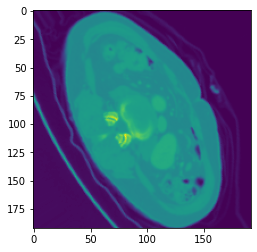

In [19]:
import matplotlib.pyplot as plt

sample_train = train_dataset[9]
plt.imshow(sample_train[0][0][PATCH_SIZE//2])

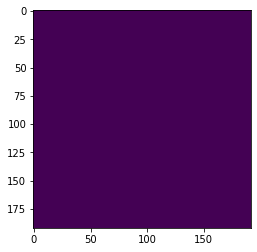

In [20]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

# Dataloader 

In [21]:
import multiprocessing
multiprocessing.cpu_count()

48

In [22]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [23]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [24]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [25]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [26]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import ResidualUNet3D, DropResidualUNet3D

def initModel():    
    segmentation_model = DropResidualUNet3D(in_channels=1, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=LEVELS)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.0001, weight_decay=0.00002)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [27]:
segmentation_model

DataParallel(
  (module): DropResidualUNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DropResNetBlock(
          (conv1): SingleConv(
            (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
            (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv2): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv3): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (dropout): Dropout(p=0.5, inplace=False)
          (non_linearity): ReLU(inplace=True)
        )
      )
      (1): Encoder(
    

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

141492707

In [29]:
from util.util import enumerateWithEstimate

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLossVal(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    ceLoss = nn.BCELoss()
    ceLoss_g = ceLoss(prediction_g, label_g.float())
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + ceLoss_g + fnLoss_g.mean() * FN_LOSS 

def computeBatchLossVal(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean()

def diceLoss(prediction_g, label_g, epsilon=0.00001):
    diceLabel_g = label_g.sum(dim=[1,2,3])
    dicePrediction_g = prediction_g.sum(dim=[1,2,3])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return 1 - diceRatio_g

In [30]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [31]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [32]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [33]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 20
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-06-22 11:44:07,563 INFO     pid:361255 3DUnet:001:<module> Starting traning...


In [34]:
for g in optimizer.param_groups:
    g['lr'] = 0.00005
    g['weight_decay'] = 0.00001

In [ ]:
for epoch_ndx in range(1, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-06-22 11:44:07,578 INFO     pid:361255 3DUnet:008:<module> Epoch 1 of 1000, 60/35 batches of size 1*4
2022-06-22 11:44:07,581 WARNING  pid:361255 util.util:221:enumerateWithEstimate E1 Training ----/60, starting
2022-06-22 11:45:08,897 INFO     pid:361255 util.util:241:enumerateWithEstimate E1 Training   16/60, done at 2022-06-22 11:46:56, 0:02:10
2022-06-22 11:45:49,402 INFO     pid:361255 util.util:241:enumerateWithEstimate E1 Training   32/60, done at 2022-06-22 11:46:57, 0:02:11
2022-06-22 11:46:57,181 WARNING  pid:361255 util.util:252:enumerateWithEstimate E1 Training ----/60, done at 2022-06-22 11:46:57
2022-06-22 11:46:57,185 INFO     pid:361255 3DUnet:007:logMetrics E1 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 11:46:57,187 INFO     pid:361255 3DUnet:043:logMetrics E1 trn      0.2690 loss, 0.8162 precision, 0.7391 recall, 0.7757 f1 score
2022-06-22 11:46:57,188 INFO     pid:361255 3DUnet:051:logMetrics E1 trn_all  0.2690 loss,  73.9% tp,  26.1% fn,     

2022-06-22 12:03:07,299 INFO     pid:361255 3DUnet:008:<module> Epoch 8 of 1000, 60/35 batches of size 1*4
2022-06-22 12:03:07,303 WARNING  pid:361255 util.util:221:enumerateWithEstimate E8 Training ----/60, starting
2022-06-22 12:03:57,273 INFO     pid:361255 util.util:241:enumerateWithEstimate E8 Training   16/60, done at 2022-06-22 12:05:45, 0:02:10
2022-06-22 12:04:37,479 INFO     pid:361255 util.util:241:enumerateWithEstimate E8 Training   32/60, done at 2022-06-22 12:05:45, 0:02:10
2022-06-22 12:05:45,326 WARNING  pid:361255 util.util:252:enumerateWithEstimate E8 Training ----/60, done at 2022-06-22 12:05:45
2022-06-22 12:05:45,328 INFO     pid:361255 3DUnet:007:logMetrics E8 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 12:05:45,329 INFO     pid:361255 3DUnet:043:logMetrics E8 trn      0.2624 loss, 0.8247 precision, 0.7535 recall, 0.7875 f1 score
2022-06-22 12:05:45,330 INFO     pid:361255 3DUnet:051:logMetrics E8 trn_all  0.2624 loss,  75.4% tp,  24.6% fn,     

2022-06-22 12:24:13,181 WARNING  pid:361255 util.util:221:enumerateWithEstimate E16 Training ----/60, starting
2022-06-22 12:25:03,429 INFO     pid:361255 util.util:241:enumerateWithEstimate E16 Training   16/60, done at 2022-06-22 12:26:51, 0:02:10
2022-06-22 12:25:43,610 INFO     pid:361255 util.util:241:enumerateWithEstimate E16 Training   32/60, done at 2022-06-22 12:26:51, 0:02:10
2022-06-22 12:26:51,514 WARNING  pid:361255 util.util:252:enumerateWithEstimate E16 Training ----/60, done at 2022-06-22 12:26:51
2022-06-22 12:26:51,518 INFO     pid:361255 3DUnet:007:logMetrics E16 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 12:26:51,520 INFO     pid:361255 3DUnet:043:logMetrics E16 trn      0.2459 loss, 0.8255 precision, 0.7600 recall, 0.7914 f1 score
2022-06-22 12:26:51,521 INFO     pid:361255 3DUnet:051:logMetrics E16 trn_all  0.2459 loss,  76.0% tp,  24.0% fn,      16.1% fp
2022-06-22 12:26:51,526 INFO     pid:361255 3DUnet:008:<module> Epoch 17 of 1000, 60/35 ba

2022-06-22 12:43:04,588 INFO     pid:361255 3DUnet:008:<module> Epoch 23 of 1000, 60/35 batches of size 1*4
2022-06-22 12:43:04,591 WARNING  pid:361255 util.util:221:enumerateWithEstimate E23 Training ----/60, starting
2022-06-22 12:43:54,730 INFO     pid:361255 util.util:241:enumerateWithEstimate E23 Training   16/60, done at 2022-06-22 12:45:42, 0:02:10
2022-06-22 12:44:34,936 INFO     pid:361255 util.util:241:enumerateWithEstimate E23 Training   32/60, done at 2022-06-22 12:45:42, 0:02:10
2022-06-22 12:45:42,864 WARNING  pid:361255 util.util:252:enumerateWithEstimate E23 Training ----/60, done at 2022-06-22 12:45:42
2022-06-22 12:45:42,867 INFO     pid:361255 3DUnet:007:logMetrics E23 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 12:45:42,868 INFO     pid:361255 3DUnet:043:logMetrics E23 trn      0.2482 loss, 0.8205 precision, 0.7631 recall, 0.7908 f1 score
2022-06-22 12:45:42,869 INFO     pid:361255 3DUnet:051:logMetrics E23 trn_all  0.2482 loss,  76.3% tp,  23.7% 

2022-06-22 13:04:11,467 WARNING  pid:361255 util.util:221:enumerateWithEstimate E31 Training ----/60, starting
2022-06-22 13:05:01,814 INFO     pid:361255 util.util:241:enumerateWithEstimate E31 Training   16/60, done at 2022-06-22 13:06:50, 0:02:11
2022-06-22 13:05:41,995 INFO     pid:361255 util.util:241:enumerateWithEstimate E31 Training   32/60, done at 2022-06-22 13:06:49, 0:02:10
2022-06-22 13:06:49,890 WARNING  pid:361255 util.util:252:enumerateWithEstimate E31 Training ----/60, done at 2022-06-22 13:06:49
2022-06-22 13:06:49,894 INFO     pid:361255 3DUnet:007:logMetrics E31 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 13:06:49,896 INFO     pid:361255 3DUnet:043:logMetrics E31 trn      0.2407 loss, 0.8262 precision, 0.7573 recall, 0.7903 f1 score
2022-06-22 13:06:49,897 INFO     pid:361255 3DUnet:051:logMetrics E31 trn_all  0.2407 loss,  75.7% tp,  24.3% fn,      15.9% fp
2022-06-22 13:06:49,902 INFO     pid:361255 3DUnet:008:<module> Epoch 32 of 1000, 60/35 ba

2022-06-22 13:26:08,151 INFO     pid:361255 util.util:241:enumerateWithEstimate E39 Training   16/60, done at 2022-06-22 13:27:56, 0:02:10
2022-06-22 13:26:48,356 INFO     pid:361255 util.util:241:enumerateWithEstimate E39 Training   32/60, done at 2022-06-22 13:27:56, 0:02:10
2022-06-22 13:27:56,275 WARNING  pid:361255 util.util:252:enumerateWithEstimate E39 Training ----/60, done at 2022-06-22 13:27:56
2022-06-22 13:27:56,279 INFO     pid:361255 3DUnet:007:logMetrics E39 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 13:27:56,281 INFO     pid:361255 3DUnet:043:logMetrics E39 trn      0.2536 loss, 0.8288 precision, 0.7554 recall, 0.7904 f1 score
2022-06-22 13:27:56,283 INFO     pid:361255 3DUnet:051:logMetrics E39 trn_all  0.2536 loss,  75.5% tp,  24.5% fn,      15.6% fp
2022-06-22 13:27:56,287 INFO     pid:361255 3DUnet:008:<module> Epoch 40 of 1000, 60/35 batches of size 1*4
2022-06-22 13:27:56,291 WARNING  pid:361255 util.util:221:enumerateWithEstimate E40 Training 

2022-06-22 13:44:10,174 WARNING  pid:361255 util.util:221:enumerateWithEstimate E46 Training ----/60, starting
2022-06-22 13:45:00,352 INFO     pid:361255 util.util:241:enumerateWithEstimate E46 Training   16/60, done at 2022-06-22 13:46:48, 0:02:11
2022-06-22 13:45:40,614 INFO     pid:361255 util.util:241:enumerateWithEstimate E46 Training   32/60, done at 2022-06-22 13:46:48, 0:02:10
2022-06-22 13:46:48,566 WARNING  pid:361255 util.util:252:enumerateWithEstimate E46 Training ----/60, done at 2022-06-22 13:46:48
2022-06-22 13:46:48,569 INFO     pid:361255 3DUnet:007:logMetrics E46 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 13:46:48,571 INFO     pid:361255 3DUnet:043:logMetrics E46 trn      0.2423 loss, 0.8300 precision, 0.7594 recall, 0.7931 f1 score
2022-06-22 13:46:48,572 INFO     pid:361255 3DUnet:051:logMetrics E46 trn_all  0.2423 loss,  75.9% tp,  24.1% fn,      15.6% fp
2022-06-22 13:46:48,576 INFO     pid:361255 3DUnet:008:<module> Epoch 47 of 1000, 60/35 ba

2022-06-22 14:06:06,938 INFO     pid:361255 util.util:241:enumerateWithEstimate E54 Training   16/60, done at 2022-06-22 14:07:54, 0:02:10
2022-06-22 14:06:47,161 INFO     pid:361255 util.util:241:enumerateWithEstimate E54 Training   32/60, done at 2022-06-22 14:07:55, 0:02:10
2022-06-22 14:07:55,082 WARNING  pid:361255 util.util:252:enumerateWithEstimate E54 Training ----/60, done at 2022-06-22 14:07:55
2022-06-22 14:07:55,084 INFO     pid:361255 3DUnet:007:logMetrics E54 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 14:07:55,086 INFO     pid:361255 3DUnet:043:logMetrics E54 trn      0.2358 loss, 0.8350 precision, 0.7668 recall, 0.7995 f1 score
2022-06-22 14:07:55,088 INFO     pid:361255 3DUnet:051:logMetrics E54 trn_all  0.2358 loss,  76.7% tp,  23.3% fn,      15.1% fp
2022-06-22 14:07:55,091 INFO     pid:361255 3DUnet:008:<module> Epoch 55 of 1000, 60/35 batches of size 1*4
2022-06-22 14:07:55,095 WARNING  pid:361255 util.util:221:enumerateWithEstimate E55 Training 

2022-06-22 14:24:09,225 WARNING  pid:361255 util.util:221:enumerateWithEstimate E61 Training ----/60, starting
2022-06-22 14:24:59,220 INFO     pid:361255 util.util:241:enumerateWithEstimate E61 Training   16/60, done at 2022-06-22 14:26:47, 0:02:10
2022-06-22 14:25:39,384 INFO     pid:361255 util.util:241:enumerateWithEstimate E61 Training   32/60, done at 2022-06-22 14:26:47, 0:02:10
2022-06-22 14:26:47,274 WARNING  pid:361255 util.util:252:enumerateWithEstimate E61 Training ----/60, done at 2022-06-22 14:26:47
2022-06-22 14:26:47,279 INFO     pid:361255 3DUnet:007:logMetrics E61 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 14:26:47,281 INFO     pid:361255 3DUnet:043:logMetrics E61 trn      0.2418 loss, 0.8300 precision, 0.7595 recall, 0.7932 f1 score
2022-06-22 14:26:47,282 INFO     pid:361255 3DUnet:051:logMetrics E61 trn_all  0.2418 loss,  76.0% tp,  24.0% fn,      15.6% fp
2022-06-22 14:26:47,286 INFO     pid:361255 3DUnet:008:<module> Epoch 62 of 1000, 60/35 ba

2022-06-22 14:46:04,043 INFO     pid:361255 util.util:241:enumerateWithEstimate E69 Training   16/60, done at 2022-06-22 14:47:52, 0:02:10
2022-06-22 14:46:44,348 INFO     pid:361255 util.util:241:enumerateWithEstimate E69 Training   32/60, done at 2022-06-22 14:47:52, 0:02:10
2022-06-22 14:47:52,273 WARNING  pid:361255 util.util:252:enumerateWithEstimate E69 Training ----/60, done at 2022-06-22 14:47:52
2022-06-22 14:47:52,276 INFO     pid:361255 3DUnet:007:logMetrics E69 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 14:47:52,278 INFO     pid:361255 3DUnet:043:logMetrics E69 trn      0.2300 loss, 0.8357 precision, 0.7612 recall, 0.7967 f1 score
2022-06-22 14:47:52,278 INFO     pid:361255 3DUnet:051:logMetrics E69 trn_all  0.2300 loss,  76.1% tp,  23.9% fn,      15.0% fp
2022-06-22 14:47:52,282 INFO     pid:361255 3DUnet:008:<module> Epoch 70 of 1000, 60/35 batches of size 1*4
2022-06-22 14:47:52,284 WARNING  pid:361255 util.util:221:enumerateWithEstimate E70 Training 

2022-06-22 15:07:49,795 INFO     pid:361255 util.util:241:enumerateWithEstimate E77 Training   32/60, done at 2022-06-22 15:08:57, 0:02:10
2022-06-22 15:08:57,666 WARNING  pid:361255 util.util:252:enumerateWithEstimate E77 Training ----/60, done at 2022-06-22 15:08:57
2022-06-22 15:08:57,670 INFO     pid:361255 3DUnet:007:logMetrics E77 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 15:08:57,671 INFO     pid:361255 3DUnet:043:logMetrics E77 trn      0.2470 loss, 0.8307 precision, 0.7625 recall, 0.7951 f1 score
2022-06-22 15:08:57,672 INFO     pid:361255 3DUnet:051:logMetrics E77 trn_all  0.2470 loss,  76.3% tp,  23.7% fn,      15.5% fp
2022-06-22 15:08:57,677 INFO     pid:361255 3DUnet:008:<module> Epoch 78 of 1000, 60/35 batches of size 1*4
2022-06-22 15:08:57,681 WARNING  pid:361255 util.util:221:enumerateWithEstimate E78 Training ----/60, starting
2022-06-22 15:09:48,034 INFO     pid:361255 util.util:241:enumerateWithEstimate E78 Training   16/60, done at 2022-06-22 

2022-06-22 15:26:01,419 INFO     pid:361255 util.util:241:enumerateWithEstimate E84 Training   16/60, done at 2022-06-22 15:27:49, 0:02:10
2022-06-22 15:26:41,641 INFO     pid:361255 util.util:241:enumerateWithEstimate E84 Training   32/60, done at 2022-06-22 15:27:49, 0:02:10
2022-06-22 15:27:49,582 WARNING  pid:361255 util.util:252:enumerateWithEstimate E84 Training ----/60, done at 2022-06-22 15:27:49
2022-06-22 15:27:49,585 INFO     pid:361255 3DUnet:007:logMetrics E84 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 15:27:49,587 INFO     pid:361255 3DUnet:043:logMetrics E84 trn      0.2387 loss, 0.8359 precision, 0.7670 recall, 0.7999 f1 score
2022-06-22 15:27:49,588 INFO     pid:361255 3DUnet:051:logMetrics E84 trn_all  0.2387 loss,  76.7% tp,  23.3% fn,      15.1% fp
2022-06-22 15:27:49,592 INFO     pid:361255 3DUnet:008:<module> Epoch 85 of 1000, 60/35 batches of size 1*4
2022-06-22 15:27:49,596 WARNING  pid:361255 util.util:221:enumerateWithEstimate E85 Training 

2022-06-22 15:47:47,662 INFO     pid:361255 util.util:241:enumerateWithEstimate E92 Training   32/60, done at 2022-06-22 15:48:55, 0:02:10
2022-06-22 15:48:55,583 WARNING  pid:361255 util.util:252:enumerateWithEstimate E92 Training ----/60, done at 2022-06-22 15:48:55
2022-06-22 15:48:55,587 INFO     pid:361255 3DUnet:007:logMetrics E92 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 15:48:55,588 INFO     pid:361255 3DUnet:043:logMetrics E92 trn      0.2455 loss, 0.8260 precision, 0.7589 recall, 0.7911 f1 score
2022-06-22 15:48:55,589 INFO     pid:361255 3DUnet:051:logMetrics E92 trn_all  0.2455 loss,  75.9% tp,  24.1% fn,      16.0% fp
2022-06-22 15:48:55,592 INFO     pid:361255 3DUnet:008:<module> Epoch 93 of 1000, 60/35 batches of size 1*4
2022-06-22 15:48:55,594 WARNING  pid:361255 util.util:221:enumerateWithEstimate E93 Training ----/60, starting
2022-06-22 15:49:45,647 INFO     pid:361255 util.util:241:enumerateWithEstimate E93 Training   16/60, done at 2022-06-22 

2022-06-22 16:10:02,688 WARNING  pid:361255 util.util:252:enumerateWithEstimate E100 Training ----/60, done at 2022-06-22 16:10:02
2022-06-22 16:10:02,692 INFO     pid:361255 3DUnet:007:logMetrics E100 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 16:10:02,693 INFO     pid:361255 3DUnet:043:logMetrics E100 trn      0.2295 loss, 0.8333 precision, 0.7664 recall, 0.7984 f1 score
2022-06-22 16:10:02,694 INFO     pid:361255 3DUnet:051:logMetrics E100 trn_all  0.2295 loss,  76.6% tp,  23.4% fn,      15.3% fp
2022-06-22 16:10:02,701 WARNING  pid:361255 util.util:221:enumerateWithEstimate E100 Validation  ----/35, starting
2022-06-22 16:10:10,810 INFO     pid:361255 util.util:241:enumerateWithEstimate E100 Validation    16/35, done at 2022-06-22 16:10:18, 0:00:12
2022-06-22 16:10:17,966 INFO     pid:361255 util.util:241:enumerateWithEstimate E100 Validation    32/35, done at 2022-06-22 16:10:18, 0:00:12
2022-06-22 16:10:19,151 WARNING  pid:361255 util.util:252:enumerateWithEst

2022-06-22 16:27:48,320 INFO     pid:361255 util.util:241:enumerateWithEstimate E107 Training   32/60, done at 2022-06-22 16:28:56, 0:02:10
2022-06-22 16:28:56,217 WARNING  pid:361255 util.util:252:enumerateWithEstimate E107 Training ----/60, done at 2022-06-22 16:28:56
2022-06-22 16:28:56,219 INFO     pid:361255 3DUnet:007:logMetrics E107 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 16:28:56,220 INFO     pid:361255 3DUnet:043:logMetrics E107 trn      0.2433 loss, 0.8286 precision, 0.7689 recall, 0.7976 f1 score
2022-06-22 16:28:56,220 INFO     pid:361255 3DUnet:051:logMetrics E107 trn_all  0.2433 loss,  76.9% tp,  23.1% fn,      15.9% fp
2022-06-22 16:28:56,222 INFO     pid:361255 3DUnet:008:<module> Epoch 108 of 1000, 60/35 batches of size 1*4
2022-06-22 16:28:56,224 WARNING  pid:361255 util.util:221:enumerateWithEstimate E108 Training ----/60, starting
2022-06-22 16:29:46,251 INFO     pid:361255 util.util:241:enumerateWithEstimate E108 Training   16/60, done at 202

2022-06-22 16:48:55,573 INFO     pid:361255 util.util:241:enumerateWithEstimate E115 Training   32/60, done at 2022-06-22 16:50:03, 0:02:10
2022-06-22 16:50:03,485 WARNING  pid:361255 util.util:252:enumerateWithEstimate E115 Training ----/60, done at 2022-06-22 16:50:03
2022-06-22 16:50:03,487 INFO     pid:361255 3DUnet:007:logMetrics E115 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 16:50:03,489 INFO     pid:361255 3DUnet:043:logMetrics E115 trn      0.2412 loss, 0.8351 precision, 0.7615 recall, 0.7966 f1 score
2022-06-22 16:50:03,490 INFO     pid:361255 3DUnet:051:logMetrics E115 trn_all  0.2412 loss,  76.1% tp,  23.9% fn,      15.0% fp
2022-06-22 16:50:03,493 INFO     pid:361255 3DUnet:008:<module> Epoch 116 of 1000, 60/35 batches of size 1*4
2022-06-22 16:50:03,497 WARNING  pid:361255 util.util:221:enumerateWithEstimate E116 Training ----/60, starting
2022-06-22 16:50:53,824 INFO     pid:361255 util.util:241:enumerateWithEstimate E116 Training   16/60, done at 202

2022-06-22 17:07:10,572 INFO     pid:361255 util.util:241:enumerateWithEstimate E122 Training   16/60, done at 2022-06-22 17:08:58, 0:02:10
2022-06-22 17:07:50,752 INFO     pid:361255 util.util:241:enumerateWithEstimate E122 Training   32/60, done at 2022-06-22 17:08:58, 0:02:10
2022-06-22 17:08:58,631 WARNING  pid:361255 util.util:252:enumerateWithEstimate E122 Training ----/60, done at 2022-06-22 17:08:58
2022-06-22 17:08:58,635 INFO     pid:361255 3DUnet:007:logMetrics E122 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 17:08:58,637 INFO     pid:361255 3DUnet:043:logMetrics E122 trn      0.2416 loss, 0.8395 precision, 0.7623 recall, 0.7990 f1 score
2022-06-22 17:08:58,638 INFO     pid:361255 3DUnet:051:logMetrics E122 trn_all  0.2416 loss,  76.2% tp,  23.8% fn,      14.6% fp
2022-06-22 17:08:58,642 INFO     pid:361255 3DUnet:008:<module> Epoch 123 of 1000, 60/35 batches of size 1*4
2022-06-22 17:08:58,646 WARNING  pid:361255 util.util:221:enumerateWithEstimate E123 T

2022-06-22 17:28:17,090 INFO     pid:361255 util.util:241:enumerateWithEstimate E130 Training   16/60, done at 2022-06-22 17:30:05, 0:02:10
2022-06-22 17:28:57,334 INFO     pid:361255 util.util:241:enumerateWithEstimate E130 Training   32/60, done at 2022-06-22 17:30:05, 0:02:10
2022-06-22 17:30:05,171 WARNING  pid:361255 util.util:252:enumerateWithEstimate E130 Training ----/60, done at 2022-06-22 17:30:05
2022-06-22 17:30:05,174 INFO     pid:361255 3DUnet:007:logMetrics E130 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 17:30:05,176 INFO     pid:361255 3DUnet:043:logMetrics E130 trn      0.2400 loss, 0.8383 precision, 0.7692 recall, 0.8022 f1 score
2022-06-22 17:30:05,177 INFO     pid:361255 3DUnet:051:logMetrics E130 trn_all  0.2400 loss,  76.9% tp,  23.1% fn,      14.8% fp
2022-06-22 17:30:05,181 INFO     pid:361255 3DUnet:008:<module> Epoch 131 of 1000, 60/35 batches of size 1*4
2022-06-22 17:30:05,184 WARNING  pid:361255 util.util:221:enumerateWithEstimate E131 T

2022-06-22 17:49:21,864 INFO     pid:361255 util.util:241:enumerateWithEstimate E138 Training   16/60, done at 2022-06-22 17:51:09, 0:02:10
2022-06-22 17:50:02,138 INFO     pid:361255 util.util:241:enumerateWithEstimate E138 Training   32/60, done at 2022-06-22 17:51:10, 0:02:10
2022-06-22 17:51:09,988 WARNING  pid:361255 util.util:252:enumerateWithEstimate E138 Training ----/60, done at 2022-06-22 17:51:09
2022-06-22 17:51:09,992 INFO     pid:361255 3DUnet:007:logMetrics E138 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 17:51:09,994 INFO     pid:361255 3DUnet:043:logMetrics E138 trn      0.2275 loss, 0.8379 precision, 0.7661 recall, 0.8004 f1 score
2022-06-22 17:51:09,995 INFO     pid:361255 3DUnet:051:logMetrics E138 trn_all  0.2275 loss,  76.6% tp,  23.4% fn,      14.8% fp
2022-06-22 17:51:09,999 INFO     pid:361255 3DUnet:008:<module> Epoch 139 of 1000, 60/35 batches of size 1*4
2022-06-22 17:51:10,003 WARNING  pid:361255 util.util:221:enumerateWithEstimate E139 T

2022-06-22 18:07:22,637 WARNING  pid:361255 util.util:221:enumerateWithEstimate E145 Training ----/60, starting
2022-06-22 18:08:12,362 INFO     pid:361255 util.util:241:enumerateWithEstimate E145 Training   16/60, done at 2022-06-22 18:10:00, 0:02:10
2022-06-22 18:08:52,570 INFO     pid:361255 util.util:241:enumerateWithEstimate E145 Training   32/60, done at 2022-06-22 18:10:00, 0:02:10
2022-06-22 18:10:00,395 WARNING  pid:361255 util.util:252:enumerateWithEstimate E145 Training ----/60, done at 2022-06-22 18:10:00
2022-06-22 18:10:00,398 INFO     pid:361255 3DUnet:007:logMetrics E145 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 18:10:00,399 INFO     pid:361255 3DUnet:043:logMetrics E145 trn      0.2329 loss, 0.8342 precision, 0.7715 recall, 0.8016 f1 score
2022-06-22 18:10:00,400 INFO     pid:361255 3DUnet:051:logMetrics E145 trn_all  0.2329 loss,  77.2% tp,  22.8% fn,      15.3% fp
2022-06-22 18:10:00,404 INFO     pid:361255 3DUnet:008:<module> Epoch 146 of 1000, 

2022-06-22 18:28:26,763 WARNING  pid:361255 util.util:221:enumerateWithEstimate E153 Training ----/60, starting
2022-06-22 18:29:16,826 INFO     pid:361255 util.util:241:enumerateWithEstimate E153 Training   16/60, done at 2022-06-22 18:31:04, 0:02:10
2022-06-22 18:29:57,094 INFO     pid:361255 util.util:241:enumerateWithEstimate E153 Training   32/60, done at 2022-06-22 18:31:05, 0:02:10
2022-06-22 18:31:05,042 WARNING  pid:361255 util.util:252:enumerateWithEstimate E153 Training ----/60, done at 2022-06-22 18:31:05
2022-06-22 18:31:05,044 INFO     pid:361255 3DUnet:007:logMetrics E153 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 18:31:05,046 INFO     pid:361255 3DUnet:043:logMetrics E153 trn      0.2421 loss, 0.8392 precision, 0.7687 recall, 0.8024 f1 score
2022-06-22 18:31:05,046 INFO     pid:361255 3DUnet:051:logMetrics E153 trn_all  0.2421 loss,  76.9% tp,  23.1% fn,      14.7% fp
2022-06-22 18:31:05,050 INFO     pid:361255 3DUnet:008:<module> Epoch 154 of 1000, 

2022-06-22 18:49:38,947 INFO     pid:361255 util.util:241:enumerateWithEstimate E160 Validation    16/35, done at 2022-06-22 18:49:46, 0:00:12
2022-06-22 18:49:46,113 INFO     pid:361255 util.util:241:enumerateWithEstimate E160 Validation    32/35, done at 2022-06-22 18:49:47, 0:00:12
2022-06-22 18:49:47,289 WARNING  pid:361255 util.util:252:enumerateWithEstimate E160 Validation  ----/35, done at 2022-06-22 18:49:47
2022-06-22 18:49:48,351 INFO     pid:361255 3DUnet:007:logMetrics E160 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 18:49:48,352 INFO     pid:361255 3DUnet:043:logMetrics E160 val      0.4656 loss, 0.6009 precision, 0.6080 recall, 0.6045 f1 score
2022-06-22 18:49:48,353 INFO     pid:361255 3DUnet:051:logMetrics E160 val_all  0.4656 loss,  60.8% tp,  39.2% fn,      40.4% fp
2022-06-22 18:49:52,079 INFO     pid:361255 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_model_epoch160
2022-

2022-06-22 19:08:21,106 INFO     pid:361255 3DUnet:008:<module> Epoch 168 of 1000, 60/35 batches of size 1*4
2022-06-22 19:08:21,110 WARNING  pid:361255 util.util:221:enumerateWithEstimate E168 Training ----/60, starting
2022-06-22 19:09:10,977 INFO     pid:361255 util.util:241:enumerateWithEstimate E168 Training   16/60, done at 2022-06-22 19:10:59, 0:02:11
2022-06-22 19:09:51,209 INFO     pid:361255 util.util:241:enumerateWithEstimate E168 Training   32/60, done at 2022-06-22 19:10:59, 0:02:10
2022-06-22 19:10:59,096 WARNING  pid:361255 util.util:252:enumerateWithEstimate E168 Training ----/60, done at 2022-06-22 19:10:59
2022-06-22 19:10:59,100 INFO     pid:361255 3DUnet:007:logMetrics E168 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 19:10:59,102 INFO     pid:361255 3DUnet:043:logMetrics E168 trn      0.2370 loss, 0.8402 precision, 0.7661 recall, 0.8015 f1 score
2022-06-22 19:10:59,103 INFO     pid:361255 3DUnet:051:logMetrics E168 trn_all  0.2370 loss,  76.6% tp,

2022-06-22 19:29:25,441 INFO     pid:361255 3DUnet:008:<module> Epoch 176 of 1000, 60/35 batches of size 1*4
2022-06-22 19:29:25,445 WARNING  pid:361255 util.util:221:enumerateWithEstimate E176 Training ----/60, starting
2022-06-22 19:30:15,143 INFO     pid:361255 util.util:241:enumerateWithEstimate E176 Training   16/60, done at 2022-06-22 19:32:03, 0:02:10
2022-06-22 19:30:55,373 INFO     pid:361255 util.util:241:enumerateWithEstimate E176 Training   32/60, done at 2022-06-22 19:32:03, 0:02:10
2022-06-22 19:32:03,213 WARNING  pid:361255 util.util:252:enumerateWithEstimate E176 Training ----/60, done at 2022-06-22 19:32:03
2022-06-22 19:32:03,215 INFO     pid:361255 3DUnet:007:logMetrics E176 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 19:32:03,217 INFO     pid:361255 3DUnet:043:logMetrics E176 trn      0.2373 loss, 0.8344 precision, 0.7771 recall, 0.8048 f1 score
2022-06-22 19:32:03,218 INFO     pid:361255 3DUnet:051:logMetrics E176 trn_all  0.2373 loss,  77.7% tp,

2022-06-22 19:48:14,632 INFO     pid:361255 3DUnet:051:logMetrics E182 trn_all  0.2368 loss,  77.8% tp,  22.2% fn,      15.2% fp
2022-06-22 19:48:14,638 INFO     pid:361255 3DUnet:008:<module> Epoch 183 of 1000, 60/35 batches of size 1*4
2022-06-22 19:48:14,642 WARNING  pid:361255 util.util:221:enumerateWithEstimate E183 Training ----/60, starting
2022-06-22 19:49:04,174 INFO     pid:361255 util.util:241:enumerateWithEstimate E183 Training   16/60, done at 2022-06-22 19:50:52, 0:02:10
2022-06-22 19:49:44,381 INFO     pid:361255 util.util:241:enumerateWithEstimate E183 Training   32/60, done at 2022-06-22 19:50:52, 0:02:10
2022-06-22 19:50:52,248 WARNING  pid:361255 util.util:252:enumerateWithEstimate E183 Training ----/60, done at 2022-06-22 19:50:52
2022-06-22 19:50:52,251 INFO     pid:361255 3DUnet:007:logMetrics E183 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 19:50:52,253 INFO     pid:361255 3DUnet:043:logMetrics E183 trn      0.2266 loss, 0.8381 precision, 0.769

2022-06-22 20:09:19,204 INFO     pid:361255 3DUnet:051:logMetrics E190 trn_all  0.2265 loss,  76.8% tp,  23.2% fn,      14.7% fp
2022-06-22 20:09:19,207 INFO     pid:361255 3DUnet:008:<module> Epoch 191 of 1000, 60/35 batches of size 1*4
2022-06-22 20:09:19,210 WARNING  pid:361255 util.util:221:enumerateWithEstimate E191 Training ----/60, starting
2022-06-22 20:10:09,250 INFO     pid:361255 util.util:241:enumerateWithEstimate E191 Training   16/60, done at 2022-06-22 20:11:57, 0:02:10
2022-06-22 20:10:49,481 INFO     pid:361255 util.util:241:enumerateWithEstimate E191 Training   32/60, done at 2022-06-22 20:11:57, 0:02:10
2022-06-22 20:11:57,325 WARNING  pid:361255 util.util:252:enumerateWithEstimate E191 Training ----/60, done at 2022-06-22 20:11:57
2022-06-22 20:11:57,329 INFO     pid:361255 3DUnet:007:logMetrics E191 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 20:11:57,331 INFO     pid:361255 3DUnet:043:logMetrics E191 trn      0.2367 loss, 0.8365 precision, 0.766

2022-06-22 20:30:26,221 INFO     pid:361255 3DUnet:051:logMetrics E198 trn_all  0.2351 loss,  77.3% tp,  22.7% fn,      15.4% fp
2022-06-22 20:30:26,224 INFO     pid:361255 3DUnet:008:<module> Epoch 199 of 1000, 60/35 batches of size 1*4
2022-06-22 20:30:26,226 WARNING  pid:361255 util.util:221:enumerateWithEstimate E199 Training ----/60, starting
2022-06-22 20:31:16,249 INFO     pid:361255 util.util:241:enumerateWithEstimate E199 Training   16/60, done at 2022-06-22 20:33:04, 0:02:10
2022-06-22 20:31:56,507 INFO     pid:361255 util.util:241:enumerateWithEstimate E199 Training   32/60, done at 2022-06-22 20:33:04, 0:02:10
2022-06-22 20:33:04,432 WARNING  pid:361255 util.util:252:enumerateWithEstimate E199 Training ----/60, done at 2022-06-22 20:33:04
2022-06-22 20:33:04,436 INFO     pid:361255 3DUnet:007:logMetrics E199 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 20:33:04,437 INFO     pid:361255 3DUnet:043:logMetrics E199 trn      0.2232 loss, 0.8405 precision, 0.776

2022-06-22 20:49:17,691 INFO     pid:361255 3DUnet:043:logMetrics E205 trn      0.2279 loss, 0.8339 precision, 0.7769 recall, 0.8044 f1 score
2022-06-22 20:49:17,692 INFO     pid:361255 3DUnet:051:logMetrics E205 trn_all  0.2279 loss,  77.7% tp,  22.3% fn,      15.5% fp
2022-06-22 20:49:17,695 INFO     pid:361255 3DUnet:008:<module> Epoch 206 of 1000, 60/35 batches of size 1*4
2022-06-22 20:49:17,699 WARNING  pid:361255 util.util:221:enumerateWithEstimate E206 Training ----/60, starting
2022-06-22 20:50:07,538 INFO     pid:361255 util.util:241:enumerateWithEstimate E206 Training   16/60, done at 2022-06-22 20:51:55, 0:02:10
2022-06-22 20:50:47,763 INFO     pid:361255 util.util:241:enumerateWithEstimate E206 Training   32/60, done at 2022-06-22 20:51:55, 0:02:10
2022-06-22 20:51:55,647 WARNING  pid:361255 util.util:252:enumerateWithEstimate E206 Training ----/60, done at 2022-06-22 20:51:55
2022-06-22 20:51:55,652 INFO     pid:361255 3DUnet:007:logMetrics E206 Unet bonemeta_fn_0_3D_Unet

2022-06-22 21:10:23,356 INFO     pid:361255 3DUnet:043:logMetrics E213 trn      0.2249 loss, 0.8383 precision, 0.7772 recall, 0.8066 f1 score
2022-06-22 21:10:23,357 INFO     pid:361255 3DUnet:051:logMetrics E213 trn_all  0.2249 loss,  77.7% tp,  22.3% fn,      15.0% fp
2022-06-22 21:10:23,359 INFO     pid:361255 3DUnet:008:<module> Epoch 214 of 1000, 60/35 batches of size 1*4
2022-06-22 21:10:23,363 WARNING  pid:361255 util.util:221:enumerateWithEstimate E214 Training ----/60, starting
2022-06-22 21:11:13,410 INFO     pid:361255 util.util:241:enumerateWithEstimate E214 Training   16/60, done at 2022-06-22 21:13:01, 0:02:10
2022-06-22 21:11:53,637 INFO     pid:361255 util.util:241:enumerateWithEstimate E214 Training   32/60, done at 2022-06-22 21:13:01, 0:02:10
2022-06-22 21:13:01,556 WARNING  pid:361255 util.util:252:enumerateWithEstimate E214 Training ----/60, done at 2022-06-22 21:13:01
2022-06-22 21:13:01,559 INFO     pid:361255 3DUnet:007:logMetrics E214 Unet bonemeta_fn_0_3D_Unet

2022-06-22 21:29:09,844 INFO     pid:361255 3DUnet:051:logMetrics E220 val_all  0.4497 loss,  60.2% tp,  39.8% fn,      42.8% fp
2022-06-22 21:29:13,642 INFO     pid:361255 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_model_epoch220
2022-06-22 21:29:16,689 INFO     pid:361255 3DUnet:032:saveModel SHA1: 2cffefb0feac791c58bc6be6163cf23a5cff89cd
2022-06-22 21:29:16,691 INFO     pid:361255 3DUnet:008:<module> Epoch 221 of 1000, 60/35 batches of size 1*4
2022-06-22 21:29:16,694 WARNING  pid:361255 util.util:221:enumerateWithEstimate E221 Training ----/60, starting
2022-06-22 21:30:06,876 INFO     pid:361255 util.util:241:enumerateWithEstimate E221 Training   16/60, done at 2022-06-22 21:31:54, 0:02:10
2022-06-22 21:30:47,054 INFO     pid:361255 util.util:241:enumerateWithEstimate E221 Training   32/60, done at 2022-06-22 21:31:54, 0:02:10
2022-06-22 21:31:54,905 WARNING  pid:361255 util.util:252:enumerateWithEstima

2022-06-22 21:50:20,438 INFO     pid:361255 3DUnet:007:logMetrics E228 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 21:50:20,439 INFO     pid:361255 3DUnet:043:logMetrics E228 trn      0.2310 loss, 0.8317 precision, 0.7757 recall, 0.8027 f1 score
2022-06-22 21:50:20,440 INFO     pid:361255 3DUnet:051:logMetrics E228 trn_all  0.2310 loss,  77.6% tp,  22.4% fn,      15.7% fp
2022-06-22 21:50:20,443 INFO     pid:361255 3DUnet:008:<module> Epoch 229 of 1000, 60/35 batches of size 1*4
2022-06-22 21:50:20,446 WARNING  pid:361255 util.util:221:enumerateWithEstimate E229 Training ----/60, starting
2022-06-22 21:51:10,682 INFO     pid:361255 util.util:241:enumerateWithEstimate E229 Training   16/60, done at 2022-06-22 21:52:58, 0:02:10
2022-06-22 21:51:50,862 INFO     pid:361255 util.util:241:enumerateWithEstimate E229 Training   32/60, done at 2022-06-22 21:52:58, 0:02:10
2022-06-22 21:52:58,674 WARNING  pid:361255 util.util:252:enumerateWithEstimate E229 Training ----/60, do

2022-06-22 22:11:25,344 INFO     pid:361255 3DUnet:007:logMetrics E236 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 22:11:25,345 INFO     pid:361255 3DUnet:043:logMetrics E236 trn      0.2334 loss, 0.8373 precision, 0.7751 recall, 0.8050 f1 score
2022-06-22 22:11:25,346 INFO     pid:361255 3DUnet:051:logMetrics E236 trn_all  0.2334 loss,  77.5% tp,  22.5% fn,      15.1% fp
2022-06-22 22:11:25,349 INFO     pid:361255 3DUnet:008:<module> Epoch 237 of 1000, 60/35 batches of size 1*4
2022-06-22 22:11:25,352 WARNING  pid:361255 util.util:221:enumerateWithEstimate E237 Training ----/60, starting
2022-06-22 22:12:15,294 INFO     pid:361255 util.util:241:enumerateWithEstimate E237 Training   16/60, done at 2022-06-22 22:14:03, 0:02:10
2022-06-22 22:12:55,498 INFO     pid:361255 util.util:241:enumerateWithEstimate E237 Training   32/60, done at 2022-06-22 22:14:03, 0:02:10
2022-06-22 22:14:03,362 WARNING  pid:361255 util.util:252:enumerateWithEstimate E237 Training ----/60, do

2022-06-22 22:30:14,568 WARNING  pid:361255 util.util:252:enumerateWithEstimate E243 Training ----/60, done at 2022-06-22 22:30:14
2022-06-22 22:30:14,571 INFO     pid:361255 3DUnet:007:logMetrics E243 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 22:30:14,572 INFO     pid:361255 3DUnet:043:logMetrics E243 trn      0.2230 loss, 0.8453 precision, 0.7761 recall, 0.8092 f1 score
2022-06-22 22:30:14,573 INFO     pid:361255 3DUnet:051:logMetrics E243 trn_all  0.2230 loss,  77.6% tp,  22.4% fn,      14.2% fp
2022-06-22 22:30:14,576 INFO     pid:361255 3DUnet:008:<module> Epoch 244 of 1000, 60/35 batches of size 1*4
2022-06-22 22:30:14,579 WARNING  pid:361255 util.util:221:enumerateWithEstimate E244 Training ----/60, starting
2022-06-22 22:31:03,742 INFO     pid:361255 util.util:241:enumerateWithEstimate E244 Training   16/60, done at 2022-06-22 22:32:51, 0:02:10
2022-06-22 22:31:44,006 INFO     pid:361255 util.util:241:enumerateWithEstimate E244 Training   32/60, done at 202

2022-06-22 22:51:22,368 WARNING  pid:361255 util.util:252:enumerateWithEstimate E251 Training ----/60, done at 2022-06-22 22:51:22
2022-06-22 22:51:22,372 INFO     pid:361255 3DUnet:007:logMetrics E251 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 22:51:22,374 INFO     pid:361255 3DUnet:043:logMetrics E251 trn      0.2446 loss, 0.8412 precision, 0.7772 recall, 0.8079 f1 score
2022-06-22 22:51:22,376 INFO     pid:361255 3DUnet:051:logMetrics E251 trn_all  0.2446 loss,  77.7% tp,  22.3% fn,      14.7% fp
2022-06-22 22:51:22,381 INFO     pid:361255 3DUnet:008:<module> Epoch 252 of 1000, 60/35 batches of size 1*4
2022-06-22 22:51:22,385 WARNING  pid:361255 util.util:221:enumerateWithEstimate E252 Training ----/60, starting
2022-06-22 22:52:13,242 INFO     pid:361255 util.util:241:enumerateWithEstimate E252 Training   16/60, done at 2022-06-22 22:54:01, 0:02:10
2022-06-22 22:52:53,507 INFO     pid:361255 util.util:241:enumerateWithEstimate E252 Training   32/60, done at 202

2022-06-22 23:12:31,388 WARNING  pid:361255 util.util:252:enumerateWithEstimate E259 Training ----/60, done at 2022-06-22 23:12:31
2022-06-22 23:12:31,392 INFO     pid:361255 3DUnet:007:logMetrics E259 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 23:12:31,394 INFO     pid:361255 3DUnet:043:logMetrics E259 trn      0.2166 loss, 0.8384 precision, 0.7816 recall, 0.8090 f1 score
2022-06-22 23:12:31,395 INFO     pid:361255 3DUnet:051:logMetrics E259 trn_all  0.2166 loss,  78.2% tp,  21.8% fn,      15.1% fp
2022-06-22 23:12:31,400 INFO     pid:361255 3DUnet:008:<module> Epoch 260 of 1000, 60/35 batches of size 1*4
2022-06-22 23:12:31,404 WARNING  pid:361255 util.util:221:enumerateWithEstimate E260 Training ----/60, starting
2022-06-22 23:13:21,501 INFO     pid:361255 util.util:241:enumerateWithEstimate E260 Training   16/60, done at 2022-06-22 23:15:09, 0:02:10
2022-06-22 23:14:01,717 INFO     pid:361255 util.util:241:enumerateWithEstimate E260 Training   32/60, done at 202

2022-06-22 23:30:16,158 INFO     pid:361255 util.util:241:enumerateWithEstimate E266 Training   32/60, done at 2022-06-22 23:31:24, 0:02:10
2022-06-22 23:31:24,003 WARNING  pid:361255 util.util:252:enumerateWithEstimate E266 Training ----/60, done at 2022-06-22 23:31:24
2022-06-22 23:31:24,007 INFO     pid:361255 3DUnet:007:logMetrics E266 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 23:31:24,009 INFO     pid:361255 3DUnet:043:logMetrics E266 trn      0.2340 loss, 0.8375 precision, 0.7710 recall, 0.8029 f1 score
2022-06-22 23:31:24,010 INFO     pid:361255 3DUnet:051:logMetrics E266 trn_all  0.2340 loss,  77.1% tp,  22.9% fn,      15.0% fp
2022-06-22 23:31:24,013 INFO     pid:361255 3DUnet:008:<module> Epoch 267 of 1000, 60/35 batches of size 1*4
2022-06-22 23:31:24,017 WARNING  pid:361255 util.util:221:enumerateWithEstimate E267 Training ----/60, starting
2022-06-22 23:32:14,605 INFO     pid:361255 util.util:241:enumerateWithEstimate E267 Training   16/60, done at 202

2022-06-22 23:51:21,727 INFO     pid:361255 util.util:241:enumerateWithEstimate E274 Training   32/60, done at 2022-06-22 23:52:29, 0:02:10
2022-06-22 23:52:29,590 WARNING  pid:361255 util.util:252:enumerateWithEstimate E274 Training ----/60, done at 2022-06-22 23:52:29
2022-06-22 23:52:29,594 INFO     pid:361255 3DUnet:007:logMetrics E274 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 23:52:29,596 INFO     pid:361255 3DUnet:043:logMetrics E274 trn      0.2370 loss, 0.8420 precision, 0.7752 recall, 0.8072 f1 score
2022-06-22 23:52:29,598 INFO     pid:361255 3DUnet:051:logMetrics E274 trn_all  0.2370 loss,  77.5% tp,  22.5% fn,      14.5% fp
2022-06-22 23:52:29,602 INFO     pid:361255 3DUnet:008:<module> Epoch 275 of 1000, 60/35 batches of size 1*4
2022-06-22 23:52:29,606 WARNING  pid:361255 util.util:221:enumerateWithEstimate E275 Training ----/60, starting
2022-06-22 23:53:20,117 INFO     pid:361255 util.util:241:enumerateWithEstimate E275 Training   16/60, done at 202

2022-06-23 00:09:34,788 INFO     pid:361255 util.util:241:enumerateWithEstimate E281 Training   16/60, done at 2022-06-23 00:11:23, 0:02:11
2022-06-23 00:10:15,101 INFO     pid:361255 util.util:241:enumerateWithEstimate E281 Training   32/60, done at 2022-06-23 00:11:23, 0:02:11
2022-06-23 00:11:23,087 WARNING  pid:361255 util.util:252:enumerateWithEstimate E281 Training ----/60, done at 2022-06-23 00:11:23
2022-06-23 00:11:23,090 INFO     pid:361255 3DUnet:007:logMetrics E281 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-23 00:11:23,092 INFO     pid:361255 3DUnet:043:logMetrics E281 trn      0.2255 loss, 0.8395 precision, 0.7835 recall, 0.8106 f1 score
2022-06-23 00:11:23,093 INFO     pid:361255 3DUnet:051:logMetrics E281 trn_all  0.2255 loss,  78.4% tp,  21.6% fn,      15.0% fp
2022-06-23 00:11:23,097 INFO     pid:361255 3DUnet:008:<module> Epoch 282 of 1000, 60/35 batches of size 1*4
2022-06-23 00:11:23,102 WARNING  pid:361255 util.util:221:enumerateWithEstimate E282 T

2022-06-23 00:30:39,910 INFO     pid:361255 util.util:241:enumerateWithEstimate E289 Training   16/60, done at 2022-06-23 00:32:27, 0:02:10
2022-06-23 00:31:20,141 INFO     pid:361255 util.util:241:enumerateWithEstimate E289 Training   32/60, done at 2022-06-23 00:32:28, 0:02:10
2022-06-23 00:32:28,027 WARNING  pid:361255 util.util:252:enumerateWithEstimate E289 Training ----/60, done at 2022-06-23 00:32:28
2022-06-23 00:32:28,030 INFO     pid:361255 3DUnet:007:logMetrics E289 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-23 00:32:28,032 INFO     pid:361255 3DUnet:043:logMetrics E289 trn      0.2183 loss, 0.8455 precision, 0.7821 recall, 0.8126 f1 score
2022-06-23 00:32:28,033 INFO     pid:361255 3DUnet:051:logMetrics E289 trn_all  0.2183 loss,  78.2% tp,  21.8% fn,      14.3% fp
2022-06-23 00:32:28,037 INFO     pid:361255 3DUnet:008:<module> Epoch 290 of 1000, 60/35 batches of size 1*4
2022-06-23 00:32:28,041 WARNING  pid:361255 util.util:221:enumerateWithEstimate E290 T

2022-06-23 00:51:46,121 INFO     pid:361255 util.util:241:enumerateWithEstimate E297 Training   16/60, done at 2022-06-23 00:53:34, 0:02:10
2022-06-23 00:52:26,383 INFO     pid:361255 util.util:241:enumerateWithEstimate E297 Training   32/60, done at 2022-06-23 00:53:34, 0:02:10
2022-06-23 00:53:34,309 WARNING  pid:361255 util.util:252:enumerateWithEstimate E297 Training ----/60, done at 2022-06-23 00:53:34
2022-06-23 00:53:34,314 INFO     pid:361255 3DUnet:007:logMetrics E297 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-23 00:53:34,315 INFO     pid:361255 3DUnet:043:logMetrics E297 trn      0.2286 loss, 0.8400 precision, 0.7716 recall, 0.8043 f1 score
2022-06-23 00:53:34,316 INFO     pid:361255 3DUnet:051:logMetrics E297 trn_all  0.2286 loss,  77.2% tp,  22.8% fn,      14.7% fp
2022-06-23 00:53:34,320 INFO     pid:361255 3DUnet:008:<module> Epoch 298 of 1000, 60/35 batches of size 1*4
2022-06-23 00:53:34,324 WARNING  pid:361255 util.util:221:enumerateWithEstimate E298 T

2022-06-23 01:09:45,984 WARNING  pid:361255 util.util:221:enumerateWithEstimate E304 Training ----/60, starting
2022-06-23 01:10:35,707 INFO     pid:361255 util.util:241:enumerateWithEstimate E304 Training   16/60, done at 2022-06-23 01:12:23, 0:02:10
2022-06-23 01:11:15,908 INFO     pid:361255 util.util:241:enumerateWithEstimate E304 Training   32/60, done at 2022-06-23 01:12:23, 0:02:10
2022-06-23 01:12:23,743 WARNING  pid:361255 util.util:252:enumerateWithEstimate E304 Training ----/60, done at 2022-06-23 01:12:23
2022-06-23 01:12:23,745 INFO     pid:361255 3DUnet:007:logMetrics E304 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-23 01:12:23,746 INFO     pid:361255 3DUnet:043:logMetrics E304 trn      0.2211 loss, 0.8452 precision, 0.7789 recall, 0.8107 f1 score
2022-06-23 01:12:23,747 INFO     pid:361255 3DUnet:051:logMetrics E304 trn_all  0.2211 loss,  77.9% tp,  22.1% fn,      14.3% fp
2022-06-23 01:12:23,750 INFO     pid:361255 3DUnet:008:<module> Epoch 305 of 1000, 

2022-06-23 01:30:51,569 WARNING  pid:361255 util.util:221:enumerateWithEstimate E312 Training ----/60, starting
2022-06-23 01:31:41,763 INFO     pid:361255 util.util:241:enumerateWithEstimate E312 Training   16/60, done at 2022-06-23 01:33:30, 0:02:10
2022-06-23 01:32:21,988 INFO     pid:361255 util.util:241:enumerateWithEstimate E312 Training   32/60, done at 2022-06-23 01:33:29, 0:02:10
2022-06-23 01:33:29,921 WARNING  pid:361255 util.util:252:enumerateWithEstimate E312 Training ----/60, done at 2022-06-23 01:33:29
2022-06-23 01:33:29,924 INFO     pid:361255 3DUnet:007:logMetrics E312 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-23 01:33:29,926 INFO     pid:361255 3DUnet:043:logMetrics E312 trn      0.2278 loss, 0.8415 precision, 0.7797 recall, 0.8095 f1 score
2022-06-23 01:33:29,927 INFO     pid:361255 3DUnet:051:logMetrics E312 trn_all  0.2278 loss,  78.0% tp,  22.0% fn,      14.7% fp
2022-06-23 01:33:29,931 INFO     pid:361255 3DUnet:008:<module> Epoch 313 of 1000, 

2022-06-23 01:51:59,908 WARNING  pid:361255 util.util:221:enumerateWithEstimate E320 Training ----/60, starting


In [35]:
EPOCHS = 1500

In [36]:
for g in optimizer.param_groups:
    g['lr'] = 0.00005
    g['weight_decay'] = 0.00001

In [37]:
for epoch_ndx in range(1001, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-06-21 22:14:07,686 INFO     pid:3055 3DUnet:008:<module> Epoch 1001 of 1500, 60/35 batches of size 1*4
2022-06-21 22:14:07,689 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1001 Training ----/60, starting
2022-06-21 22:14:57,053 INFO     pid:3055 util.util:241:enumerateWithEstimate E1001 Training   16/60, done at 2022-06-21 22:16:45, 0:02:10
2022-06-21 22:15:37,278 INFO     pid:3055 util.util:241:enumerateWithEstimate E1001 Training   32/60, done at 2022-06-21 22:16:45, 0:02:10
2022-06-21 22:16:45,055 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1001 Training ----/60, done at 2022-06-21 22:16:45
2022-06-21 22:16:45,059 INFO     pid:3055 3DUnet:007:logMetrics E1001 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-21 22:16:45,060 INFO     pid:3055 3DUnet:043:logMetrics E1001 trn      0.2627 loss, 0.8180 precision, 0.7470 recall, 0.7809 f1 score
2022-06-21 22:16:45,061 INFO     pid:3055 3DUnet:051:logMetrics E1001 trn_all  0.2627 loss,  74.7% tp,  25.3% 

2022-06-21 22:35:08,406 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1009 Training ----/60, starting
2022-06-21 22:35:58,005 INFO     pid:3055 util.util:241:enumerateWithEstimate E1009 Training   16/60, done at 2022-06-21 22:37:46, 0:02:10
2022-06-21 22:36:38,267 INFO     pid:3055 util.util:241:enumerateWithEstimate E1009 Training   32/60, done at 2022-06-21 22:37:46, 0:02:10
2022-06-21 22:37:46,184 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1009 Training ----/60, done at 2022-06-21 22:37:46
2022-06-21 22:37:46,188 INFO     pid:3055 3DUnet:007:logMetrics E1009 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-21 22:37:46,189 INFO     pid:3055 3DUnet:043:logMetrics E1009 trn      0.2433 loss, 0.8244 precision, 0.7574 recall, 0.7895 f1 score
2022-06-21 22:37:46,190 INFO     pid:3055 3DUnet:051:logMetrics E1009 trn_all  0.2433 loss,  75.7% tp,  24.3% fn,      16.1% fp
2022-06-21 22:37:46,195 INFO     pid:3055 3DUnet:008:<module> Epoch 1010 of 1500, 60/35 ba

2022-06-21 22:56:58,379 INFO     pid:3055 util.util:241:enumerateWithEstimate E1017 Training   16/60, done at 2022-06-21 22:58:46, 0:02:10
2022-06-21 22:57:38,658 INFO     pid:3055 util.util:241:enumerateWithEstimate E1017 Training   32/60, done at 2022-06-21 22:58:46, 0:02:10
2022-06-21 22:58:46,582 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1017 Training ----/60, done at 2022-06-21 22:58:46
2022-06-21 22:58:46,586 INFO     pid:3055 3DUnet:007:logMetrics E1017 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-21 22:58:46,589 INFO     pid:3055 3DUnet:043:logMetrics E1017 trn      0.2496 loss, 0.8283 precision, 0.7618 recall, 0.7936 f1 score
2022-06-21 22:58:46,590 INFO     pid:3055 3DUnet:051:logMetrics E1017 trn_all  0.2496 loss,  76.2% tp,  23.8% fn,      15.8% fp
2022-06-21 22:58:46,594 INFO     pid:3055 3DUnet:008:<module> Epoch 1018 of 1500, 60/35 batches of size 1*4
2022-06-21 22:58:46,598 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1018 Training 

2022-06-21 23:14:54,664 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1024 Training ----/60, starting
2022-06-21 23:15:44,305 INFO     pid:3055 util.util:241:enumerateWithEstimate E1024 Training   16/60, done at 2022-06-21 23:17:32, 0:02:10
2022-06-21 23:16:24,619 INFO     pid:3055 util.util:241:enumerateWithEstimate E1024 Training   32/60, done at 2022-06-21 23:17:32, 0:02:10
2022-06-21 23:17:32,558 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1024 Training ----/60, done at 2022-06-21 23:17:32
2022-06-21 23:17:32,562 INFO     pid:3055 3DUnet:007:logMetrics E1024 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-21 23:17:32,563 INFO     pid:3055 3DUnet:043:logMetrics E1024 trn      0.2455 loss, 0.8323 precision, 0.7572 recall, 0.7930 f1 score
2022-06-21 23:17:32,565 INFO     pid:3055 3DUnet:051:logMetrics E1024 trn_all  0.2455 loss,  75.7% tp,  24.3% fn,      15.3% fp
2022-06-21 23:17:32,569 INFO     pid:3055 3DUnet:008:<module> Epoch 1025 of 1500, 60/35 ba

2022-06-21 23:36:44,689 INFO     pid:3055 util.util:241:enumerateWithEstimate E1032 Training   16/60, done at 2022-06-21 23:38:32, 0:02:10
2022-06-21 23:37:24,915 INFO     pid:3055 util.util:241:enumerateWithEstimate E1032 Training   32/60, done at 2022-06-21 23:38:32, 0:02:10
2022-06-21 23:38:32,888 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1032 Training ----/60, done at 2022-06-21 23:38:32
2022-06-21 23:38:32,892 INFO     pid:3055 3DUnet:007:logMetrics E1032 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-21 23:38:32,895 INFO     pid:3055 3DUnet:043:logMetrics E1032 trn      0.2487 loss, 0.8280 precision, 0.7591 recall, 0.7921 f1 score
2022-06-21 23:38:32,896 INFO     pid:3055 3DUnet:051:logMetrics E1032 trn_all  0.2487 loss,  75.9% tp,  24.1% fn,      15.8% fp
2022-06-21 23:38:32,900 INFO     pid:3055 3DUnet:008:<module> Epoch 1033 of 1500, 60/35 batches of size 1*4
2022-06-21 23:38:32,904 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1033 Training 

2022-06-21 23:58:26,280 INFO     pid:3055 util.util:241:enumerateWithEstimate E1040 Training   32/60, done at 2022-06-21 23:59:34, 0:02:10
2022-06-21 23:59:34,154 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1040 Training ----/60, done at 2022-06-21 23:59:34
2022-06-21 23:59:34,157 INFO     pid:3055 3DUnet:007:logMetrics E1040 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-21 23:59:34,159 INFO     pid:3055 3DUnet:043:logMetrics E1040 trn      0.2368 loss, 0.8326 precision, 0.7619 recall, 0.7957 f1 score
2022-06-21 23:59:34,160 INFO     pid:3055 3DUnet:051:logMetrics E1040 trn_all  0.2368 loss,  76.2% tp,  23.8% fn,      15.3% fp
2022-06-21 23:59:34,167 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1040 Validation  ----/35, starting
2022-06-21 23:59:41,626 INFO     pid:3055 util.util:241:enumerateWithEstimate E1040 Validation    16/35, done at 2022-06-21 23:59:49, 0:00:12
2022-06-21 23:59:48,786 INFO     pid:3055 util.util:241:enumerateWithEstimate E1040 

2022-06-22 00:16:32,151 INFO     pid:3055 util.util:241:enumerateWithEstimate E1047 Training   16/60, done at 2022-06-22 00:18:20, 0:02:10
2022-06-22 00:17:12,444 INFO     pid:3055 util.util:241:enumerateWithEstimate E1047 Training   32/60, done at 2022-06-22 00:18:20, 0:02:10
2022-06-22 00:18:20,324 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1047 Training ----/60, done at 2022-06-22 00:18:20
2022-06-22 00:18:20,327 INFO     pid:3055 3DUnet:007:logMetrics E1047 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 00:18:20,328 INFO     pid:3055 3DUnet:043:logMetrics E1047 trn      0.2366 loss, 0.8261 precision, 0.7608 recall, 0.7921 f1 score
2022-06-22 00:18:20,330 INFO     pid:3055 3DUnet:051:logMetrics E1047 trn_all  0.2366 loss,  76.1% tp,  23.9% fn,      16.0% fp
2022-06-22 00:18:20,334 INFO     pid:3055 3DUnet:008:<module> Epoch 1048 of 1500, 60/35 batches of size 1*4
2022-06-22 00:18:20,338 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1048 Training 

2022-06-22 00:38:13,251 INFO     pid:3055 util.util:241:enumerateWithEstimate E1055 Training   32/60, done at 2022-06-22 00:39:21, 0:02:10
2022-06-22 00:39:21,089 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1055 Training ----/60, done at 2022-06-22 00:39:21
2022-06-22 00:39:21,092 INFO     pid:3055 3DUnet:007:logMetrics E1055 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 00:39:21,094 INFO     pid:3055 3DUnet:043:logMetrics E1055 trn      0.2426 loss, 0.8289 precision, 0.7631 recall, 0.7946 f1 score
2022-06-22 00:39:21,096 INFO     pid:3055 3DUnet:051:logMetrics E1055 trn_all  0.2426 loss,  76.3% tp,  23.7% fn,      15.8% fp
2022-06-22 00:39:21,100 INFO     pid:3055 3DUnet:008:<module> Epoch 1056 of 1500, 60/35 batches of size 1*4
2022-06-22 00:39:21,104 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1056 Training ----/60, starting
2022-06-22 00:40:10,312 INFO     pid:3055 util.util:241:enumerateWithEstimate E1056 Training   16/60, done at 2022-06-22 

2022-06-22 00:56:19,958 INFO     pid:3055 util.util:241:enumerateWithEstimate E1062 Training   16/60, done at 2022-06-22 00:58:11, 0:02:15
2022-06-22 00:57:00,214 INFO     pid:3055 util.util:241:enumerateWithEstimate E1062 Training   32/60, done at 2022-06-22 00:58:08, 0:02:12
2022-06-22 00:58:08,025 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1062 Training ----/60, done at 2022-06-22 00:58:08
2022-06-22 00:58:08,028 INFO     pid:3055 3DUnet:007:logMetrics E1062 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 00:58:08,030 INFO     pid:3055 3DUnet:043:logMetrics E1062 trn      0.2401 loss, 0.8267 precision, 0.7634 recall, 0.7937 f1 score
2022-06-22 00:58:08,031 INFO     pid:3055 3DUnet:051:logMetrics E1062 trn_all  0.2401 loss,  76.3% tp,  23.7% fn,      16.0% fp
2022-06-22 00:58:08,036 INFO     pid:3055 3DUnet:008:<module> Epoch 1063 of 1500, 60/35 batches of size 1*4
2022-06-22 00:58:08,039 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1063 Training 

2022-06-22 01:18:01,544 INFO     pid:3055 util.util:241:enumerateWithEstimate E1070 Training   32/60, done at 2022-06-22 01:19:09, 0:02:10
2022-06-22 01:19:09,382 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1070 Training ----/60, done at 2022-06-22 01:19:09
2022-06-22 01:19:09,386 INFO     pid:3055 3DUnet:007:logMetrics E1070 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 01:19:09,388 INFO     pid:3055 3DUnet:043:logMetrics E1070 trn      0.2352 loss, 0.8335 precision, 0.7688 recall, 0.7998 f1 score
2022-06-22 01:19:09,389 INFO     pid:3055 3DUnet:051:logMetrics E1070 trn_all  0.2352 loss,  76.9% tp,  23.1% fn,      15.4% fp
2022-06-22 01:19:09,393 INFO     pid:3055 3DUnet:008:<module> Epoch 1071 of 1500, 60/35 batches of size 1*4
2022-06-22 01:19:09,397 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1071 Training ----/60, starting
2022-06-22 01:19:59,238 INFO     pid:3055 util.util:241:enumerateWithEstimate E1071 Training   16/60, done at 2022-06-22 

2022-06-22 01:40:10,330 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1078 Training ----/60, done at 2022-06-22 01:40:10
2022-06-22 01:40:10,334 INFO     pid:3055 3DUnet:007:logMetrics E1078 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 01:40:10,336 INFO     pid:3055 3DUnet:043:logMetrics E1078 trn      0.2289 loss, 0.8386 precision, 0.7782 recall, 0.8073 f1 score
2022-06-22 01:40:10,337 INFO     pid:3055 3DUnet:051:logMetrics E1078 trn_all  0.2289 loss,  77.8% tp,  22.2% fn,      15.0% fp
2022-06-22 01:40:10,342 INFO     pid:3055 3DUnet:008:<module> Epoch 1079 of 1500, 60/35 batches of size 1*4
2022-06-22 01:40:10,346 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1079 Training ----/60, starting
2022-06-22 01:40:59,867 INFO     pid:3055 util.util:241:enumerateWithEstimate E1079 Training   16/60, done at 2022-06-22 01:42:47, 0:02:10
2022-06-22 01:41:40,097 INFO     pid:3055 util.util:241:enumerateWithEstimate E1079 Training   32/60, done at 2022-06-22 

2022-06-22 01:57:49,227 INFO     pid:3055 util.util:241:enumerateWithEstimate E1085 Training   32/60, done at 2022-06-22 01:58:57, 0:02:10
2022-06-22 01:58:57,107 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1085 Training ----/60, done at 2022-06-22 01:58:57
2022-06-22 01:58:57,110 INFO     pid:3055 3DUnet:007:logMetrics E1085 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 01:58:57,111 INFO     pid:3055 3DUnet:043:logMetrics E1085 trn      0.2393 loss, 0.8298 precision, 0.7656 recall, 0.7964 f1 score
2022-06-22 01:58:57,113 INFO     pid:3055 3DUnet:051:logMetrics E1085 trn_all  0.2393 loss,  76.6% tp,  23.4% fn,      15.7% fp
2022-06-22 01:58:57,117 INFO     pid:3055 3DUnet:008:<module> Epoch 1086 of 1500, 60/35 batches of size 1*4
2022-06-22 01:58:57,121 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1086 Training ----/60, starting
2022-06-22 01:59:46,549 INFO     pid:3055 util.util:241:enumerateWithEstimate E1086 Training   16/60, done at 2022-06-22 

2022-06-22 02:19:59,094 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1093 Training ----/60, done at 2022-06-22 02:19:59
2022-06-22 02:19:59,098 INFO     pid:3055 3DUnet:007:logMetrics E1093 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 02:19:59,100 INFO     pid:3055 3DUnet:043:logMetrics E1093 trn      0.2439 loss, 0.8300 precision, 0.7681 recall, 0.7978 f1 score
2022-06-22 02:19:59,101 INFO     pid:3055 3DUnet:051:logMetrics E1093 trn_all  0.2439 loss,  76.8% tp,  23.2% fn,      15.7% fp
2022-06-22 02:19:59,105 INFO     pid:3055 3DUnet:008:<module> Epoch 1094 of 1500, 60/35 batches of size 1*4
2022-06-22 02:19:59,109 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1094 Training ----/60, starting
2022-06-22 02:20:48,770 INFO     pid:3055 util.util:241:enumerateWithEstimate E1094 Training   16/60, done at 2022-06-22 02:22:37, 0:02:11
2022-06-22 02:21:29,005 INFO     pid:3055 util.util:241:enumerateWithEstimate E1094 Training   32/60, done at 2022-06-22 

2022-06-22 02:38:39,498 INFO     pid:3055 3DUnet:043:logMetrics E1100 val      0.4636 loss, 0.5983 precision, 0.6127 recall, 0.6054 f1 score
2022-06-22 02:38:39,499 INFO     pid:3055 3DUnet:051:logMetrics E1100 val_all  0.4636 loss,  61.3% tp,  38.7% fn,      41.1% fp
2022-06-22 02:38:43,228 INFO     pid:3055 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_model_epoch1100
2022-06-22 02:38:46,077 INFO     pid:3055 3DUnet:032:saveModel SHA1: 13e98ea2283af34a421d1fbe767ea75381236123
2022-06-22 02:38:46,079 INFO     pid:3055 3DUnet:008:<module> Epoch 1101 of 1500, 60/35 batches of size 1*4
2022-06-22 02:38:46,082 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1101 Training ----/60, starting
2022-06-22 02:39:35,687 INFO     pid:3055 util.util:241:enumerateWithEstimate E1101 Training   16/60, done at 2022-06-22 02:41:23, 0:02:10
2022-06-22 02:40:15,913 INFO     pid:3055 util.util:241:enumerateWithEstimate E1101

2022-06-22 02:59:46,627 INFO     pid:3055 3DUnet:007:logMetrics E1108 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 02:59:46,629 INFO     pid:3055 3DUnet:043:logMetrics E1108 trn      0.2376 loss, 0.8289 precision, 0.7646 recall, 0.7955 f1 score
2022-06-22 02:59:46,630 INFO     pid:3055 3DUnet:051:logMetrics E1108 trn_all  0.2376 loss,  76.5% tp,  23.5% fn,      15.8% fp
2022-06-22 02:59:46,633 INFO     pid:3055 3DUnet:008:<module> Epoch 1109 of 1500, 60/35 batches of size 1*4
2022-06-22 02:59:46,637 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1109 Training ----/60, starting
2022-06-22 03:00:36,415 INFO     pid:3055 util.util:241:enumerateWithEstimate E1109 Training   16/60, done at 2022-06-22 03:02:24, 0:02:10
2022-06-22 03:01:16,661 INFO     pid:3055 util.util:241:enumerateWithEstimate E1109 Training   32/60, done at 2022-06-22 03:02:24, 0:02:10
2022-06-22 03:02:24,541 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1109 Training ----/60, done at 20

2022-06-22 03:20:48,309 INFO     pid:3055 3DUnet:043:logMetrics E1116 trn      0.2383 loss, 0.8344 precision, 0.7767 recall, 0.8045 f1 score
2022-06-22 03:20:48,311 INFO     pid:3055 3DUnet:051:logMetrics E1116 trn_all  0.2383 loss,  77.7% tp,  22.3% fn,      15.4% fp
2022-06-22 03:20:48,314 INFO     pid:3055 3DUnet:008:<module> Epoch 1117 of 1500, 60/35 batches of size 1*4
2022-06-22 03:20:48,317 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1117 Training ----/60, starting
2022-06-22 03:21:37,777 INFO     pid:3055 util.util:241:enumerateWithEstimate E1117 Training   16/60, done at 2022-06-22 03:23:25, 0:02:10
2022-06-22 03:22:18,055 INFO     pid:3055 util.util:241:enumerateWithEstimate E1117 Training   32/60, done at 2022-06-22 03:23:25, 0:02:10
2022-06-22 03:23:25,951 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1117 Training ----/60, done at 2022-06-22 03:23:25
2022-06-22 03:23:25,954 INFO     pid:3055 3DUnet:007:logMetrics E1117 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-06-22 03:39:35,543 INFO     pid:3055 3DUnet:007:logMetrics E1123 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 03:39:35,545 INFO     pid:3055 3DUnet:043:logMetrics E1123 trn      0.2380 loss, 0.8278 precision, 0.7621 recall, 0.7936 f1 score
2022-06-22 03:39:35,546 INFO     pid:3055 3DUnet:051:logMetrics E1123 trn_all  0.2380 loss,  76.2% tp,  23.8% fn,      15.9% fp
2022-06-22 03:39:35,549 INFO     pid:3055 3DUnet:008:<module> Epoch 1124 of 1500, 60/35 batches of size 1*4
2022-06-22 03:39:35,552 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1124 Training ----/60, starting
2022-06-22 03:40:25,136 INFO     pid:3055 util.util:241:enumerateWithEstimate E1124 Training   16/60, done at 2022-06-22 03:42:13, 0:02:11
2022-06-22 03:41:05,359 INFO     pid:3055 util.util:241:enumerateWithEstimate E1124 Training   32/60, done at 2022-06-22 03:42:13, 0:02:10
2022-06-22 03:42:13,219 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1124 Training ----/60, done at 20

2022-06-22 04:00:36,090 INFO     pid:3055 3DUnet:043:logMetrics E1131 trn      0.2396 loss, 0.8353 precision, 0.7704 recall, 0.8016 f1 score
2022-06-22 04:00:36,091 INFO     pid:3055 3DUnet:051:logMetrics E1131 trn_all  0.2396 loss,  77.0% tp,  23.0% fn,      15.2% fp
2022-06-22 04:00:36,095 INFO     pid:3055 3DUnet:008:<module> Epoch 1132 of 1500, 60/35 batches of size 1*4
2022-06-22 04:00:36,099 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1132 Training ----/60, starting
2022-06-22 04:01:25,881 INFO     pid:3055 util.util:241:enumerateWithEstimate E1132 Training   16/60, done at 2022-06-22 04:03:13, 0:02:10
2022-06-22 04:02:06,103 INFO     pid:3055 util.util:241:enumerateWithEstimate E1132 Training   32/60, done at 2022-06-22 04:03:13, 0:02:10
2022-06-22 04:03:14,046 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1132 Training ----/60, done at 2022-06-22 04:03:14
2022-06-22 04:03:14,050 INFO     pid:3055 3DUnet:007:logMetrics E1132 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-06-22 04:21:38,992 INFO     pid:3055 3DUnet:051:logMetrics E1139 trn_all  0.2404 loss,  77.3% tp,  22.7% fn,      14.9% fp
2022-06-22 04:21:38,995 INFO     pid:3055 3DUnet:008:<module> Epoch 1140 of 1500, 60/35 batches of size 1*4
2022-06-22 04:21:38,999 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1140 Training ----/60, starting
2022-06-22 04:22:28,637 INFO     pid:3055 util.util:241:enumerateWithEstimate E1140 Training   16/60, done at 2022-06-22 04:24:16, 0:02:10
2022-06-22 04:23:08,889 INFO     pid:3055 util.util:241:enumerateWithEstimate E1140 Training   32/60, done at 2022-06-22 04:24:16, 0:02:10
2022-06-22 04:24:16,792 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1140 Training ----/60, done at 2022-06-22 04:24:16
2022-06-22 04:24:16,795 INFO     pid:3055 3DUnet:007:logMetrics E1140 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 04:24:16,797 INFO     pid:3055 3DUnet:043:logMetrics E1140 trn      0.2312 loss, 0.8395 precision, 0.7671 recall

2022-06-22 04:40:26,204 INFO     pid:3055 3DUnet:043:logMetrics E1146 trn      0.2437 loss, 0.8325 precision, 0.7699 recall, 0.8000 f1 score
2022-06-22 04:40:26,205 INFO     pid:3055 3DUnet:051:logMetrics E1146 trn_all  0.2437 loss,  77.0% tp,  23.0% fn,      15.5% fp
2022-06-22 04:40:26,209 INFO     pid:3055 3DUnet:008:<module> Epoch 1147 of 1500, 60/35 batches of size 1*4
2022-06-22 04:40:26,213 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1147 Training ----/60, starting
2022-06-22 04:41:15,532 INFO     pid:3055 util.util:241:enumerateWithEstimate E1147 Training   16/60, done at 2022-06-22 04:43:03, 0:02:10
2022-06-22 04:41:55,778 INFO     pid:3055 util.util:241:enumerateWithEstimate E1147 Training   32/60, done at 2022-06-22 04:43:03, 0:02:10
2022-06-22 04:43:03,642 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1147 Training ----/60, done at 2022-06-22 04:43:03
2022-06-22 04:43:03,647 INFO     pid:3055 3DUnet:007:logMetrics E1147 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-06-22 05:01:27,434 INFO     pid:3055 3DUnet:051:logMetrics E1154 trn_all  0.2427 loss,  77.7% tp,  22.3% fn,      15.4% fp
2022-06-22 05:01:27,437 INFO     pid:3055 3DUnet:008:<module> Epoch 1155 of 1500, 60/35 batches of size 1*4
2022-06-22 05:01:27,440 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1155 Training ----/60, starting
2022-06-22 05:02:17,040 INFO     pid:3055 util.util:241:enumerateWithEstimate E1155 Training   16/60, done at 2022-06-22 05:04:05, 0:02:10
2022-06-22 05:02:57,316 INFO     pid:3055 util.util:241:enumerateWithEstimate E1155 Training   32/60, done at 2022-06-22 05:04:05, 0:02:10
2022-06-22 05:04:05,167 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1155 Training ----/60, done at 2022-06-22 05:04:05
2022-06-22 05:04:05,169 INFO     pid:3055 3DUnet:007:logMetrics E1155 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 05:04:05,170 INFO     pid:3055 3DUnet:043:logMetrics E1155 trn      0.2399 loss, 0.8390 precision, 0.7661 recall

2022-06-22 05:20:14,554 INFO     pid:3055 3DUnet:043:logMetrics E1161 trn      0.2440 loss, 0.8405 precision, 0.7719 recall, 0.8047 f1 score
2022-06-22 05:20:14,555 INFO     pid:3055 3DUnet:051:logMetrics E1161 trn_all  0.2440 loss,  77.2% tp,  22.8% fn,      14.6% fp
2022-06-22 05:20:14,559 INFO     pid:3055 3DUnet:008:<module> Epoch 1162 of 1500, 60/35 batches of size 1*4
2022-06-22 05:20:14,563 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1162 Training ----/60, starting
2022-06-22 05:21:03,820 INFO     pid:3055 util.util:241:enumerateWithEstimate E1162 Training   16/60, done at 2022-06-22 05:22:51, 0:02:10
2022-06-22 05:21:44,039 INFO     pid:3055 util.util:241:enumerateWithEstimate E1162 Training   32/60, done at 2022-06-22 05:22:51, 0:02:10
2022-06-22 05:22:51,911 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1162 Training ----/60, done at 2022-06-22 05:22:51
2022-06-22 05:22:51,913 INFO     pid:3055 3DUnet:007:logMetrics E1162 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-06-22 05:41:16,049 INFO     pid:3055 3DUnet:051:logMetrics E1169 trn_all  0.2370 loss,  77.0% tp,  23.0% fn,      15.6% fp
2022-06-22 05:41:16,053 INFO     pid:3055 3DUnet:008:<module> Epoch 1170 of 1500, 60/35 batches of size 1*4
2022-06-22 05:41:16,057 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1170 Training ----/60, starting
2022-06-22 05:42:05,147 INFO     pid:3055 util.util:241:enumerateWithEstimate E1170 Training   16/60, done at 2022-06-22 05:43:53, 0:02:10
2022-06-22 05:42:45,367 INFO     pid:3055 util.util:241:enumerateWithEstimate E1170 Training   32/60, done at 2022-06-22 05:43:53, 0:02:10
2022-06-22 05:43:53,309 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1170 Training ----/60, done at 2022-06-22 05:43:53
2022-06-22 05:43:53,311 INFO     pid:3055 3DUnet:007:logMetrics E1170 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 05:43:53,312 INFO     pid:3055 3DUnet:043:logMetrics E1170 trn      0.2266 loss, 0.8344 precision, 0.7717 recall

2022-06-22 06:02:16,343 INFO     pid:3055 3DUnet:008:<module> Epoch 1178 of 1500, 60/35 batches of size 1*4
2022-06-22 06:02:16,347 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1178 Training ----/60, starting
2022-06-22 06:03:05,824 INFO     pid:3055 util.util:241:enumerateWithEstimate E1178 Training   16/60, done at 2022-06-22 06:04:54, 0:02:10
2022-06-22 06:03:46,099 INFO     pid:3055 util.util:241:enumerateWithEstimate E1178 Training   32/60, done at 2022-06-22 06:04:54, 0:02:10
2022-06-22 06:04:53,997 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1178 Training ----/60, done at 2022-06-22 06:04:53
2022-06-22 06:04:54,001 INFO     pid:3055 3DUnet:007:logMetrics E1178 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 06:04:54,003 INFO     pid:3055 3DUnet:043:logMetrics E1178 trn      0.2356 loss, 0.8327 precision, 0.7718 recall, 0.8011 f1 score
2022-06-22 06:04:54,005 INFO     pid:3055 3DUnet:051:logMetrics E1178 trn_all  0.2356 loss,  77.2% tp,  22.8% 

2022-06-22 06:21:02,874 INFO     pid:3055 3DUnet:051:logMetrics E1184 trn_all  0.2369 loss,  76.9% tp,  23.1% fn,      14.6% fp
2022-06-22 06:21:02,877 INFO     pid:3055 3DUnet:008:<module> Epoch 1185 of 1500, 60/35 batches of size 1*4
2022-06-22 06:21:02,880 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1185 Training ----/60, starting
2022-06-22 06:21:52,249 INFO     pid:3055 util.util:241:enumerateWithEstimate E1185 Training   16/60, done at 2022-06-22 06:23:40, 0:02:10
2022-06-22 06:22:32,471 INFO     pid:3055 util.util:241:enumerateWithEstimate E1185 Training   32/60, done at 2022-06-22 06:23:40, 0:02:10
2022-06-22 06:23:40,348 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1185 Training ----/60, done at 2022-06-22 06:23:40
2022-06-22 06:23:40,351 INFO     pid:3055 3DUnet:007:logMetrics E1185 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 06:23:40,353 INFO     pid:3055 3DUnet:043:logMetrics E1185 trn      0.2376 loss, 0.8338 precision, 0.7710 recall

2022-06-22 06:42:03,789 INFO     pid:3055 3DUnet:008:<module> Epoch 1193 of 1500, 60/35 batches of size 1*4
2022-06-22 06:42:03,792 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1193 Training ----/60, starting
2022-06-22 06:42:53,317 INFO     pid:3055 util.util:241:enumerateWithEstimate E1193 Training   16/60, done at 2022-06-22 06:44:41, 0:02:10
2022-06-22 06:43:33,620 INFO     pid:3055 util.util:241:enumerateWithEstimate E1193 Training   32/60, done at 2022-06-22 06:44:41, 0:02:10
2022-06-22 06:44:41,499 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1193 Training ----/60, done at 2022-06-22 06:44:41
2022-06-22 06:44:41,503 INFO     pid:3055 3DUnet:007:logMetrics E1193 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 06:44:41,504 INFO     pid:3055 3DUnet:043:logMetrics E1193 trn      0.2347 loss, 0.8418 precision, 0.7657 recall, 0.8020 f1 score
2022-06-22 06:44:41,505 INFO     pid:3055 3DUnet:051:logMetrics E1193 trn_all  0.2347 loss,  76.6% tp,  23.4% 

2022-06-22 07:03:11,767 INFO     pid:3055 util.util:241:enumerateWithEstimate E1200 Validation    16/35, done at 2022-06-22 07:03:19, 0:00:12
2022-06-22 07:03:18,918 INFO     pid:3055 util.util:241:enumerateWithEstimate E1200 Validation    32/35, done at 2022-06-22 07:03:19, 0:00:12
2022-06-22 07:03:20,049 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1200 Validation  ----/35, done at 2022-06-22 07:03:20
2022-06-22 07:03:21,159 INFO     pid:3055 3DUnet:007:logMetrics E1200 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 07:03:21,160 INFO     pid:3055 3DUnet:043:logMetrics E1200 val      0.4635 loss, 0.5958 precision, 0.6174 recall, 0.6064 f1 score
2022-06-22 07:03:21,161 INFO     pid:3055 3DUnet:051:logMetrics E1200 val_all  0.4635 loss,  61.7% tp,  38.3% fn,      41.9% fp
2022-06-22 07:03:24,878 INFO     pid:3055 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_model_epoch1200
2022-06-22 0

2022-06-22 07:21:50,458 INFO     pid:3055 3DUnet:008:<module> Epoch 1208 of 1500, 60/35 batches of size 1*4
2022-06-22 07:21:50,461 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1208 Training ----/60, starting
2022-06-22 07:22:39,872 INFO     pid:3055 util.util:241:enumerateWithEstimate E1208 Training   16/60, done at 2022-06-22 07:24:27, 0:02:10
2022-06-22 07:23:20,138 INFO     pid:3055 util.util:241:enumerateWithEstimate E1208 Training   32/60, done at 2022-06-22 07:24:28, 0:02:10
2022-06-22 07:24:28,022 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1208 Training ----/60, done at 2022-06-22 07:24:28
2022-06-22 07:24:28,025 INFO     pid:3055 3DUnet:007:logMetrics E1208 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 07:24:28,027 INFO     pid:3055 3DUnet:043:logMetrics E1208 trn      0.2389 loss, 0.8423 precision, 0.7665 recall, 0.8026 f1 score
2022-06-22 07:24:28,028 INFO     pid:3055 3DUnet:051:logMetrics E1208 trn_all  0.2389 loss,  76.6% tp,  23.4% 

2022-06-22 07:42:51,614 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1216 Training ----/60, starting
2022-06-22 07:43:41,116 INFO     pid:3055 util.util:241:enumerateWithEstimate E1216 Training   16/60, done at 2022-06-22 07:45:29, 0:02:10
2022-06-22 07:44:21,391 INFO     pid:3055 util.util:241:enumerateWithEstimate E1216 Training   32/60, done at 2022-06-22 07:45:29, 0:02:10
2022-06-22 07:45:29,348 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1216 Training ----/60, done at 2022-06-22 07:45:29
2022-06-22 07:45:29,351 INFO     pid:3055 3DUnet:007:logMetrics E1216 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 07:45:29,353 INFO     pid:3055 3DUnet:043:logMetrics E1216 trn      0.2361 loss, 0.8354 precision, 0.7711 recall, 0.8020 f1 score
2022-06-22 07:45:29,355 INFO     pid:3055 3DUnet:051:logMetrics E1216 trn_all  0.2361 loss,  77.1% tp,  22.9% fn,      15.2% fp
2022-06-22 07:45:29,359 INFO     pid:3055 3DUnet:008:<module> Epoch 1217 of 1500, 60/35 ba

2022-06-22 08:01:38,296 INFO     pid:3055 3DUnet:008:<module> Epoch 1223 of 1500, 60/35 batches of size 1*4
2022-06-22 08:01:38,300 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1223 Training ----/60, starting
2022-06-22 08:02:27,493 INFO     pid:3055 util.util:241:enumerateWithEstimate E1223 Training   16/60, done at 2022-06-22 08:04:15, 0:02:10
2022-06-22 08:03:07,712 INFO     pid:3055 util.util:241:enumerateWithEstimate E1223 Training   32/60, done at 2022-06-22 08:04:15, 0:02:10
2022-06-22 08:04:15,567 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1223 Training ----/60, done at 2022-06-22 08:04:15
2022-06-22 08:04:15,571 INFO     pid:3055 3DUnet:007:logMetrics E1223 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 08:04:15,573 INFO     pid:3055 3DUnet:043:logMetrics E1223 trn      0.2384 loss, 0.8331 precision, 0.7716 recall, 0.8012 f1 score
2022-06-22 08:04:15,574 INFO     pid:3055 3DUnet:051:logMetrics E1223 trn_all  0.2384 loss,  77.2% tp,  22.8% 

2022-06-22 08:22:38,776 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1231 Training ----/60, starting
2022-06-22 08:23:27,931 INFO     pid:3055 util.util:241:enumerateWithEstimate E1231 Training   16/60, done at 2022-06-22 08:25:16, 0:02:10
2022-06-22 08:24:08,187 INFO     pid:3055 util.util:241:enumerateWithEstimate E1231 Training   32/60, done at 2022-06-22 08:25:16, 0:02:10
2022-06-22 08:25:16,080 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1231 Training ----/60, done at 2022-06-22 08:25:16
2022-06-22 08:25:16,084 INFO     pid:3055 3DUnet:007:logMetrics E1231 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 08:25:16,086 INFO     pid:3055 3DUnet:043:logMetrics E1231 trn      0.2321 loss, 0.8382 precision, 0.7733 recall, 0.8044 f1 score
2022-06-22 08:25:16,087 INFO     pid:3055 3DUnet:051:logMetrics E1231 trn_all  0.2321 loss,  77.3% tp,  22.7% fn,      14.9% fp
2022-06-22 08:25:16,091 INFO     pid:3055 3DUnet:008:<module> Epoch 1232 of 1500, 60/35 ba

2022-06-22 08:44:29,397 INFO     pid:3055 util.util:241:enumerateWithEstimate E1239 Training   16/60, done at 2022-06-22 08:46:17, 0:02:10
2022-06-22 08:45:09,623 INFO     pid:3055 util.util:241:enumerateWithEstimate E1239 Training   32/60, done at 2022-06-22 08:46:17, 0:02:10
2022-06-22 08:46:17,485 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1239 Training ----/60, done at 2022-06-22 08:46:17
2022-06-22 08:46:17,489 INFO     pid:3055 3DUnet:007:logMetrics E1239 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 08:46:17,491 INFO     pid:3055 3DUnet:043:logMetrics E1239 trn      0.2401 loss, 0.8361 precision, 0.7705 recall, 0.8020 f1 score
2022-06-22 08:46:17,492 INFO     pid:3055 3DUnet:051:logMetrics E1239 trn_all  0.2401 loss,  77.1% tp,  22.9% fn,      15.1% fp
2022-06-22 08:46:17,496 INFO     pid:3055 3DUnet:008:<module> Epoch 1240 of 1500, 60/35 batches of size 1*4
2022-06-22 08:46:17,500 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1240 Training 

2022-06-22 09:02:27,171 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1246 Training ----/60, starting
2022-06-22 09:03:16,307 INFO     pid:3055 util.util:241:enumerateWithEstimate E1246 Training   16/60, done at 2022-06-22 09:05:04, 0:02:10
2022-06-22 09:03:56,534 INFO     pid:3055 util.util:241:enumerateWithEstimate E1246 Training   32/60, done at 2022-06-22 09:05:04, 0:02:10
2022-06-22 09:05:04,402 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1246 Training ----/60, done at 2022-06-22 09:05:04
2022-06-22 09:05:04,406 INFO     pid:3055 3DUnet:007:logMetrics E1246 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 09:05:04,408 INFO     pid:3055 3DUnet:043:logMetrics E1246 trn      0.2367 loss, 0.8390 precision, 0.7635 recall, 0.7995 f1 score
2022-06-22 09:05:04,409 INFO     pid:3055 3DUnet:051:logMetrics E1246 trn_all  0.2367 loss,  76.4% tp,  23.6% fn,      14.7% fp
2022-06-22 09:05:04,413 INFO     pid:3055 3DUnet:008:<module> Epoch 1247 of 1500, 60/35 ba

2022-06-22 09:24:17,041 INFO     pid:3055 util.util:241:enumerateWithEstimate E1254 Training   16/60, done at 2022-06-22 09:26:05, 0:02:10
2022-06-22 09:24:57,232 INFO     pid:3055 util.util:241:enumerateWithEstimate E1254 Training   32/60, done at 2022-06-22 09:26:05, 0:02:10
2022-06-22 09:26:05,131 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1254 Training ----/60, done at 2022-06-22 09:26:05
2022-06-22 09:26:05,135 INFO     pid:3055 3DUnet:007:logMetrics E1254 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 09:26:05,137 INFO     pid:3055 3DUnet:043:logMetrics E1254 trn      0.2290 loss, 0.8411 precision, 0.7757 recall, 0.8070 f1 score
2022-06-22 09:26:05,138 INFO     pid:3055 3DUnet:051:logMetrics E1254 trn_all  0.2290 loss,  77.6% tp,  22.4% fn,      14.7% fp
2022-06-22 09:26:05,143 INFO     pid:3055 3DUnet:008:<module> Epoch 1255 of 1500, 60/35 batches of size 1*4
2022-06-22 09:26:05,147 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1255 Training 

2022-06-22 09:42:14,898 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1261 Training ----/60, starting
2022-06-22 09:43:04,419 INFO     pid:3055 util.util:241:enumerateWithEstimate E1261 Training   16/60, done at 2022-06-22 09:44:52, 0:02:10
2022-06-22 09:43:44,636 INFO     pid:3055 util.util:241:enumerateWithEstimate E1261 Training   32/60, done at 2022-06-22 09:44:52, 0:02:10
2022-06-22 09:44:52,475 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1261 Training ----/60, done at 2022-06-22 09:44:52
2022-06-22 09:44:52,477 INFO     pid:3055 3DUnet:007:logMetrics E1261 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 09:44:52,478 INFO     pid:3055 3DUnet:043:logMetrics E1261 trn      0.2229 loss, 0.8386 precision, 0.7743 recall, 0.8051 f1 score
2022-06-22 09:44:52,478 INFO     pid:3055 3DUnet:051:logMetrics E1261 trn_all  0.2229 loss,  77.4% tp,  22.6% fn,      14.9% fp
2022-06-22 09:44:52,481 INFO     pid:3055 3DUnet:008:<module> Epoch 1262 of 1500, 60/35 ba

2022-06-22 10:04:04,894 INFO     pid:3055 util.util:241:enumerateWithEstimate E1269 Training   16/60, done at 2022-06-22 10:05:52, 0:02:10
2022-06-22 10:04:45,206 INFO     pid:3055 util.util:241:enumerateWithEstimate E1269 Training   32/60, done at 2022-06-22 10:05:53, 0:02:10
2022-06-22 10:05:53,027 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1269 Training ----/60, done at 2022-06-22 10:05:53
2022-06-22 10:05:53,030 INFO     pid:3055 3DUnet:007:logMetrics E1269 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 10:05:53,032 INFO     pid:3055 3DUnet:043:logMetrics E1269 trn      0.2337 loss, 0.8352 precision, 0.7804 recall, 0.8069 f1 score
2022-06-22 10:05:53,033 INFO     pid:3055 3DUnet:051:logMetrics E1269 trn_all  0.2337 loss,  78.0% tp,  22.0% fn,      15.4% fp
2022-06-22 10:05:53,036 INFO     pid:3055 3DUnet:008:<module> Epoch 1270 of 1500, 60/35 batches of size 1*4
2022-06-22 10:05:53,040 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1270 Training 

2022-06-22 10:25:45,531 INFO     pid:3055 util.util:241:enumerateWithEstimate E1277 Training   32/60, done at 2022-06-22 10:26:53, 0:02:10
2022-06-22 10:26:53,365 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1277 Training ----/60, done at 2022-06-22 10:26:53
2022-06-22 10:26:53,369 INFO     pid:3055 3DUnet:007:logMetrics E1277 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 10:26:53,371 INFO     pid:3055 3DUnet:043:logMetrics E1277 trn      0.2344 loss, 0.8318 precision, 0.7788 recall, 0.8045 f1 score
2022-06-22 10:26:53,372 INFO     pid:3055 3DUnet:051:logMetrics E1277 trn_all  0.2344 loss,  77.9% tp,  22.1% fn,      15.7% fp
2022-06-22 10:26:53,376 INFO     pid:3055 3DUnet:008:<module> Epoch 1278 of 1500, 60/35 batches of size 1*4
2022-06-22 10:26:53,380 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1278 Training ----/60, starting
2022-06-22 10:27:42,621 INFO     pid:3055 util.util:241:enumerateWithEstimate E1278 Training   16/60, done at 2022-06-22 

2022-06-22 10:43:51,537 INFO     pid:3055 util.util:241:enumerateWithEstimate E1284 Training   16/60, done at 2022-06-22 10:45:39, 0:02:11
2022-06-22 10:44:31,792 INFO     pid:3055 util.util:241:enumerateWithEstimate E1284 Training   32/60, done at 2022-06-22 10:45:39, 0:02:10
2022-06-22 10:45:39,680 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1284 Training ----/60, done at 2022-06-22 10:45:39
2022-06-22 10:45:39,684 INFO     pid:3055 3DUnet:007:logMetrics E1284 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 10:45:39,686 INFO     pid:3055 3DUnet:043:logMetrics E1284 trn      0.2346 loss, 0.8369 precision, 0.7721 recall, 0.8032 f1 score
2022-06-22 10:45:39,687 INFO     pid:3055 3DUnet:051:logMetrics E1284 trn_all  0.2346 loss,  77.2% tp,  22.8% fn,      15.0% fp
2022-06-22 10:45:39,692 INFO     pid:3055 3DUnet:008:<module> Epoch 1285 of 1500, 60/35 batches of size 1*4
2022-06-22 10:45:39,696 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1285 Training 

2022-06-22 11:05:33,506 INFO     pid:3055 util.util:241:enumerateWithEstimate E1292 Training   32/60, done at 2022-06-22 11:06:41, 0:02:10
2022-06-22 11:06:41,355 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1292 Training ----/60, done at 2022-06-22 11:06:41
2022-06-22 11:06:41,358 INFO     pid:3055 3DUnet:007:logMetrics E1292 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 11:06:41,361 INFO     pid:3055 3DUnet:043:logMetrics E1292 trn      0.2289 loss, 0.8369 precision, 0.7752 recall, 0.8049 f1 score
2022-06-22 11:06:41,362 INFO     pid:3055 3DUnet:051:logMetrics E1292 trn_all  0.2289 loss,  77.5% tp,  22.5% fn,      15.1% fp
2022-06-22 11:06:41,366 INFO     pid:3055 3DUnet:008:<module> Epoch 1293 of 1500, 60/35 batches of size 1*4
2022-06-22 11:06:41,370 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1293 Training ----/60, starting
2022-06-22 11:07:30,680 INFO     pid:3055 util.util:241:enumerateWithEstimate E1293 Training   16/60, done at 2022-06-22 

2022-06-22 11:27:46,770 WARNING  pid:3055 util.util:252:enumerateWithEstimate E1300 Training ----/60, done at 2022-06-22 11:27:46
2022-06-22 11:27:46,776 INFO     pid:3055 3DUnet:007:logMetrics E1300 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin
2022-06-22 11:27:46,777 INFO     pid:3055 3DUnet:043:logMetrics E1300 trn      0.2381 loss, 0.8345 precision, 0.7734 recall, 0.8028 f1 score
2022-06-22 11:27:46,779 INFO     pid:3055 3DUnet:051:logMetrics E1300 trn_all  0.2381 loss,  77.3% tp,  22.7% fn,      15.3% fp
2022-06-22 11:27:46,786 WARNING  pid:3055 util.util:221:enumerateWithEstimate E1300 Validation  ----/35, starting
2022-06-22 11:27:54,323 INFO     pid:3055 util.util:241:enumerateWithEstimate E1300 Validation    16/35, done at 2022-06-22 11:28:02, 0:00:12
2022-06-22 11:28:01,478 INFO     pid:3055 util.util:241:enumerateWithEstimate E1300 Validation    32/35, done at 2022-06-22 11:28:02, 0:00:12
2022-06-22 11:28:02,620 WARNING  pid:3055 util.util:252:enumerateWithEstimate E13

KeyboardInterrupt: 

In [ ]:
!ls $BASE_DIR/logs